In [3]:
import pandas as pd
pd.options.display.max_rows = 999
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

# Exploratory Data Analysis

In [4]:
#load data
xls = pd.ExcelFile('bank_term_deposit_marketing_analysis.xlsx')

In [5]:
#check out all the sheets
xls.sheet_names

['PROCEDURE',
 'DATA DESCRIPTION',
 'Step 1 - Collect Information',
 'CLIENT_INFO',
 'LOAN_HISTORY',
 'MARKETING HISTORY',
 'SUBSCRIPTION HISTORY',
 'Step 2 - Merge Information',
 'CLIENT_MERGE',
 'Step 3 - Marketing Analysis',
 'DAILY RANGE',
 'JOB ANALYSIS',
 'Sheet3']

In [6]:
#select only sheets that we want
#create seperate dataframe for each sheet
client_info = pd.read_excel(xls, 'CLIENT_INFO')
loan_history = pd.read_excel(xls, 'LOAN_HISTORY')
marketing_history = pd.read_excel(xls, 'MARKETING HISTORY')
subscription_history = pd.read_excel(xls, 'SUBSCRIPTION HISTORY')

In [7]:
client_info.to_csv('client_info.csv')
loan_history.to_csv('loan_history.csv')
marketing_history.to_csv('marketing_history.csv')
subscription_history.to_csv('subscription_history.csv')

In [8]:
#preview
client_info.head()

,ID,AGE,JOB,MARITAL,EDUCATION
0,2836,58,management,married,tertiary
1,2837,44,technician,single,secondary
2,2838,33,entrepreneur,married,secondary
3,2839,47,blue-collar,married,unknown
4,2840,33,unknown,single,unknown


In [9]:
client_info['AGE'].describe()

count    45211.000000
mean        40.936210
std         10.618762
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: AGE, dtype: float64

In [10]:
client_info['JOB'].value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: JOB, dtype: int64

In [11]:
client_info['MARITAL'].value_counts()

married     27214
single      12790
divorced     5207
Name: MARITAL, dtype: int64

In [12]:
client_info['EDUCATION'].value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: EDUCATION, dtype: int64

In [13]:
#preview
loan_history.head()

,ID,DEFAULT,BALANCE,HOUSING,LOAN
0,2836,no,2143,yes,no
1,2837,no,29,yes,no
2,2838,no,2,yes,yes
3,2839,no,1506,yes,no
4,2840,no,1,no,no


In [14]:
loan_history['DEFAULT'].value_counts()

no     44396
yes      815
Name: DEFAULT, dtype: int64

In [15]:
loan_history['BALANCE'].describe()

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: BALANCE, dtype: float64

In [16]:
loan_history['HOUSING'].value_counts()

yes    25130
no     20081
Name: HOUSING, dtype: int64

In [17]:
loan_history['LOAN'].value_counts()

no     37967
yes     7244
Name: LOAN, dtype: int64

In [18]:
#preview
marketing_history.head()

,ID,CONTACT,DAY,MONTH,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME
0,2836,unknown,5,may,261,1,-1,0,unknown
1,2837,unknown,5,may,151,1,-1,0,unknown
2,2838,unknown,5,may,76,1,-1,0,unknown
3,2839,unknown,5,may,92,1,-1,0,unknown
4,2840,unknown,5,may,198,1,-1,0,unknown


In [19]:
marketing_history['CONTACT'].value_counts()

cellular     29285
unknown      13020
telephone     2906
Name: CONTACT, dtype: int64

In [20]:
marketing_history['DAY'].value_counts()

20    2752
18    2308
21    2026
17    1939
6     1932
5     1910
14    1848
8     1842
28    1830
7     1817
19    1757
29    1745
15    1703
12    1603
13    1585
30    1566
9     1561
11    1479
4     1445
16    1415
2     1293
27    1121
3     1079
26    1035
23     939
22     905
25     840
31     643
10     524
24     447
1      322
Name: DAY, dtype: int64

In [21]:
marketing_history['MONTH'].value_counts()

may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: MONTH, dtype: int64

In [22]:
marketing_history['DURATION'].describe()

count    45211.000000
mean       258.163080
std        257.527812
min          0.000000
25%        103.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: DURATION, dtype: float64

In [23]:
marketing_history['CAMPAIGN'].describe()

count    45211.000000
mean         2.763841
std          3.098021
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: CAMPAIGN, dtype: float64

In [24]:
marketing_history['PDAYS'].value_counts().head()

-1      36954
 182      167
 92       147
 183      126
 91       126
Name: PDAYS, dtype: int64

In [25]:
marketing_history['PREVIOUS'].describe()

count    45211.000000
mean         0.580323
std          2.303441
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        275.000000
Name: PREVIOUS, dtype: float64

In [26]:
marketing_history['POUTCOME'].value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: POUTCOME, dtype: int64

In [27]:
#preview
subscription_history.head()

#no = client did not enroll
#yes = client enrolled
#binary classification problem

,ID,TERM_DEPOSIT
0,2836,no
1,2837,no
2,2838,no
3,2839,no
4,2840,no


In [28]:
subscription_history['TERM_DEPOSIT'].value_counts()

no     39922
yes     5289
Name: TERM_DEPOSIT, dtype: int64

In [29]:
#combine dataframe
df = pd.merge(client_info, loan_history, on=['ID'])
df = pd.merge(df, marketing_history, on=['ID'])
df = pd.merge(df, subscription_history, on=['ID'])

#preview
df.head()

,ID,AGE,JOB,MARITAL,EDUCATION,DEFAULT,BALANCE,HOUSING,LOAN,CONTACT,DAY,MONTH,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,TERM_DEPOSIT
0,2836,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,2837,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,2838,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,2839,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,2840,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [30]:
#drop 'ID' since it is not predictive
df = df.drop(columns=['ID'], axis=1)
df.head()

,AGE,JOB,MARITAL,EDUCATION,DEFAULT,BALANCE,HOUSING,LOAN,CONTACT,DAY,MONTH,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,TERM_DEPOSIT
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [31]:
df.to_csv('df.csv')

In [32]:
#info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   AGE           45211 non-null  int64 
 1   JOB           45211 non-null  object
 2   MARITAL       45211 non-null  object
 3   EDUCATION     45211 non-null  object
 4   DEFAULT       45211 non-null  object
 5   BALANCE       45211 non-null  int64 
 6   HOUSING       45211 non-null  object
 7   LOAN          45211 non-null  object
 8   CONTACT       45211 non-null  object
 9   DAY           45211 non-null  int64 
 10  MONTH         45211 non-null  object
 11  DURATION      45211 non-null  int64 
 12  CAMPAIGN      45211 non-null  int64 
 13  PDAYS         45211 non-null  int64 
 14  PREVIOUS      45211 non-null  int64 
 15  POUTCOME      45211 non-null  object
 16  TERM_DEPOSIT  45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 6.2+ MB


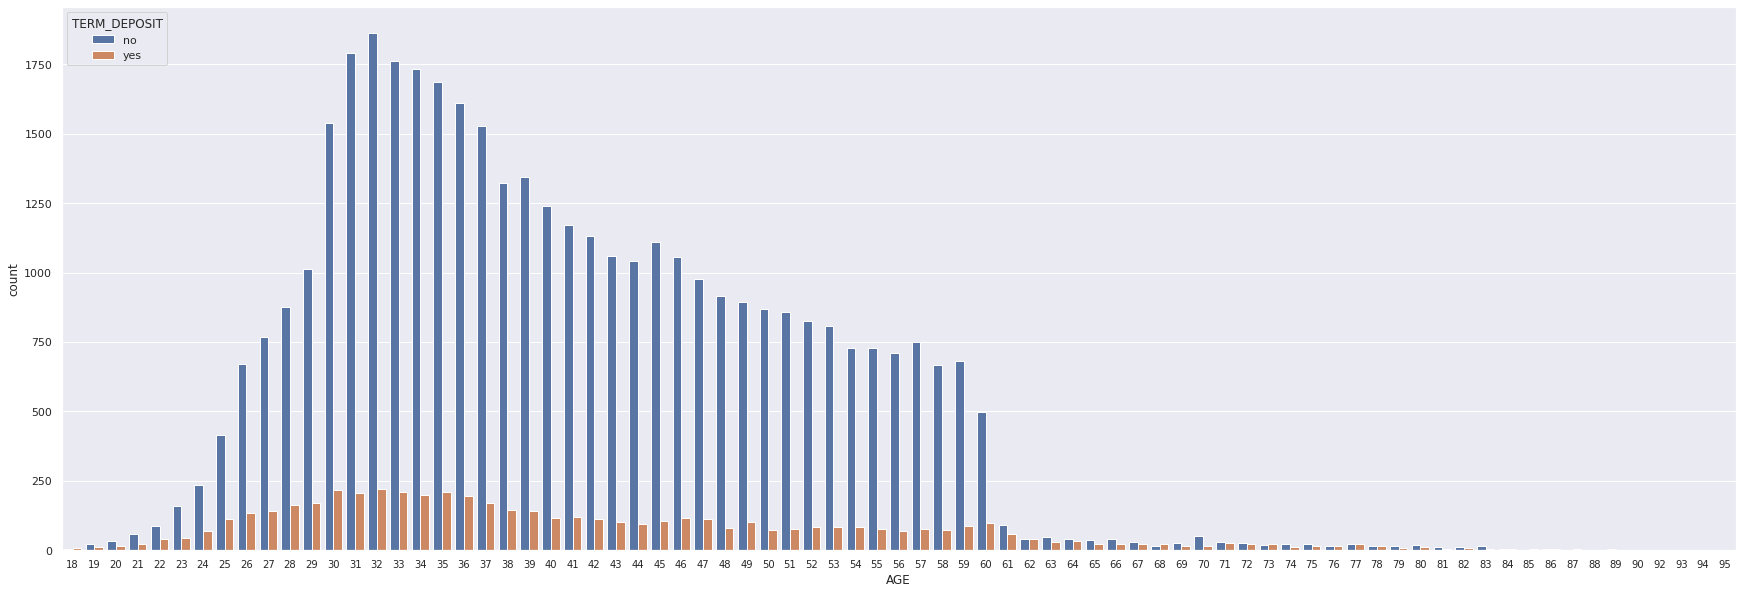

In [33]:
plt.figure(figsize = (30, 10))
sns.countplot(x="AGE", hue='TERM_DEPOSIT', data=df)
plt.xticks(fontsize=10);

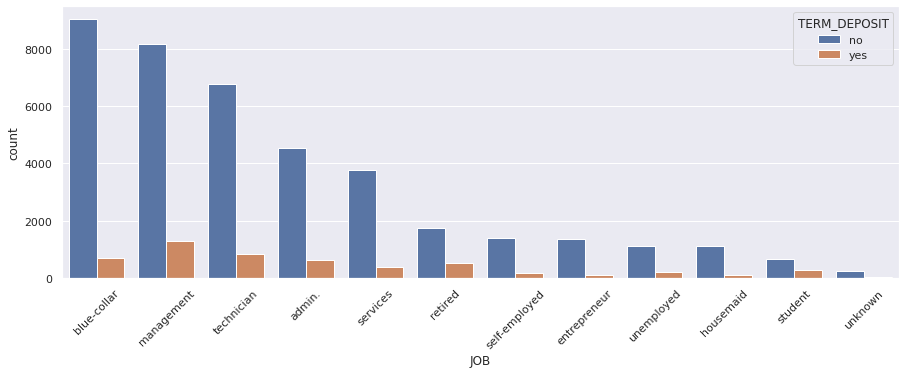

In [34]:
plt.figure(figsize = (15, 5))
sns.countplot(x="JOB", hue='TERM_DEPOSIT', data=df, order = df['JOB'].value_counts().index)
plt.xticks(rotation = 45);

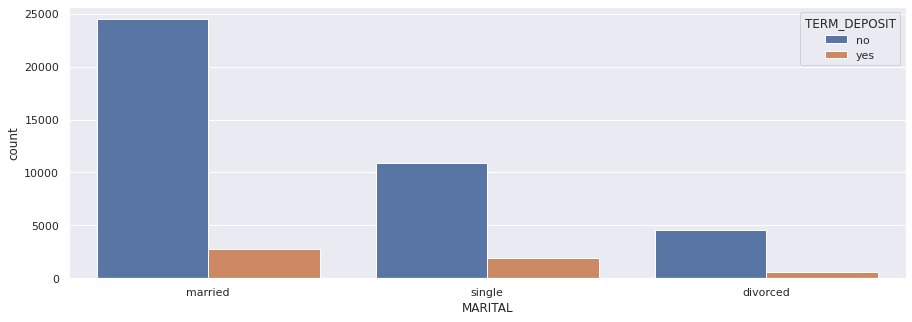

In [35]:
plt.figure(figsize = (15, 5))
sns.countplot(x="MARITAL", hue='TERM_DEPOSIT', data=df);

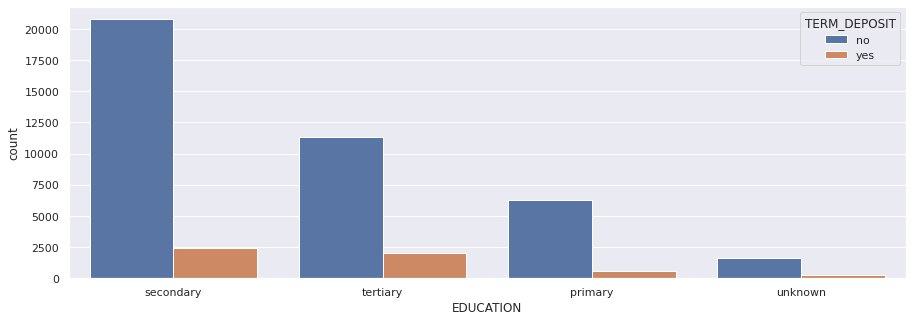

In [36]:
plt.figure(figsize = (15, 5))
sns.countplot(x="EDUCATION", hue='TERM_DEPOSIT', data=df, order = df['EDUCATION'].value_counts().index);

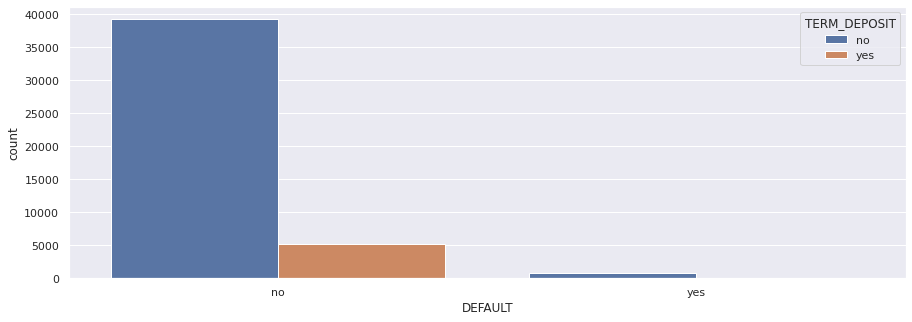

In [37]:
plt.figure(figsize = (15, 5))
sns.countplot(x="DEFAULT", hue='TERM_DEPOSIT', data=df);

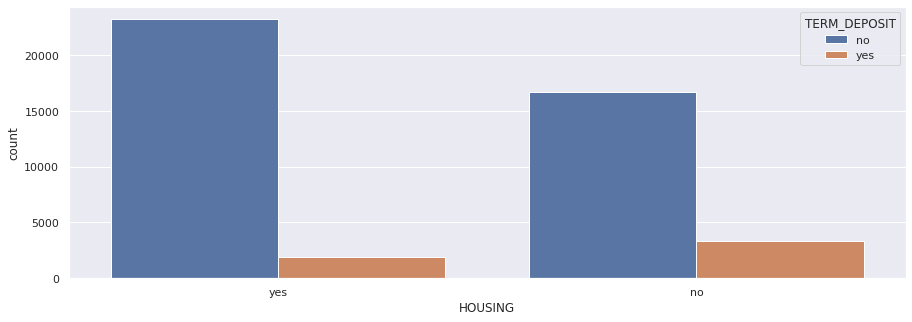

In [38]:
plt.figure(figsize = (15, 5))
sns.countplot(x="HOUSING", hue='TERM_DEPOSIT', data=df, order = df['HOUSING'].value_counts().index);

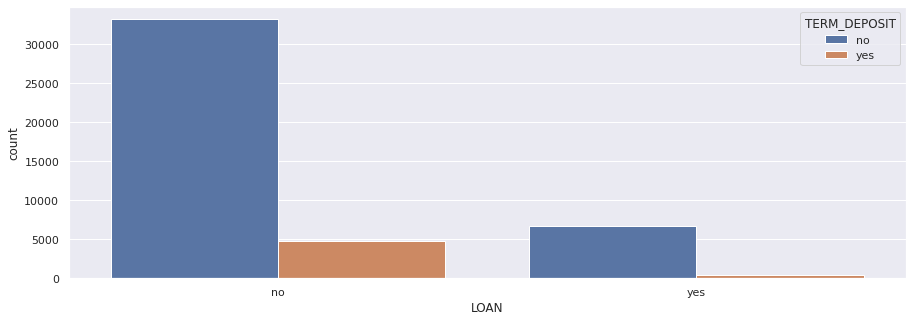

In [39]:
plt.figure(figsize = (15, 5))
sns.countplot(x="LOAN", hue='TERM_DEPOSIT', data=df);

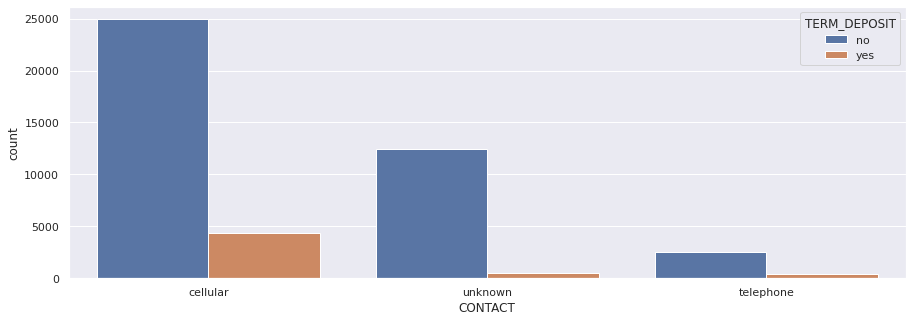

In [40]:
plt.figure(figsize = (15, 5))
sns.countplot(x="CONTACT", hue='TERM_DEPOSIT', data=df, order = df['CONTACT'].value_counts().index);

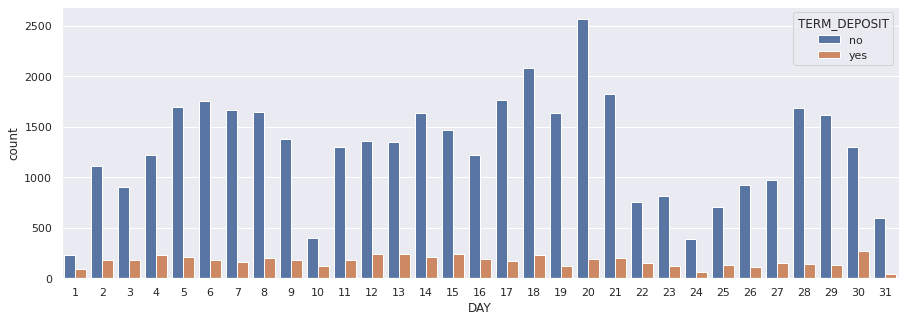

In [41]:
plt.figure(figsize = (15, 5))
sns.countplot(x="DAY", hue='TERM_DEPOSIT', data=df);

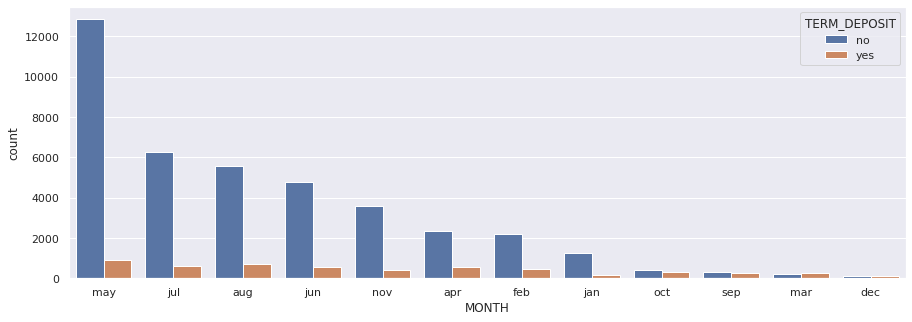

In [42]:
plt.figure(figsize = (15, 5))
sns.countplot(x="MONTH", hue='TERM_DEPOSIT', data=df, order = df['MONTH'].value_counts().index);

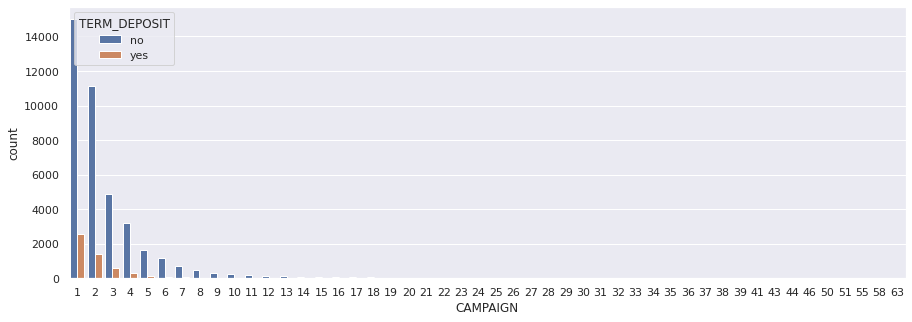

In [43]:
plt.figure(figsize = (15, 5))
sns.countplot(x="CAMPAIGN", hue='TERM_DEPOSIT', data=df);

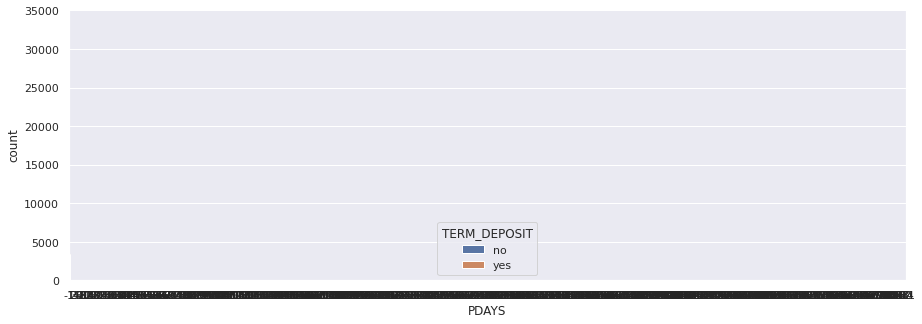

In [44]:
plt.figure(figsize = (15, 5))
sns.countplot(x="PDAYS", hue='TERM_DEPOSIT', data=df);

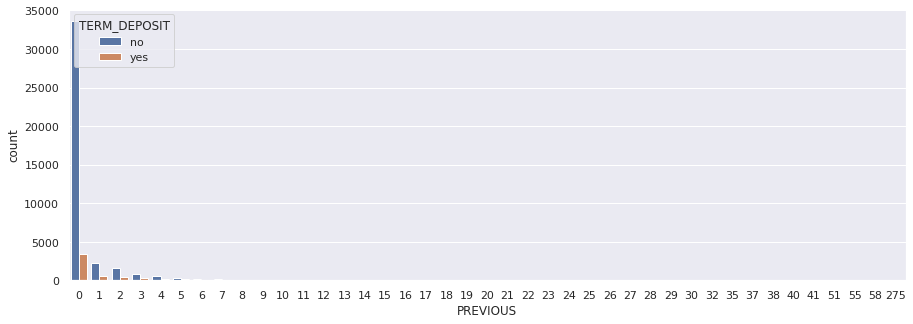

In [45]:
plt.figure(figsize = (15, 5))
sns.countplot(x="PREVIOUS", hue='TERM_DEPOSIT', data=df);

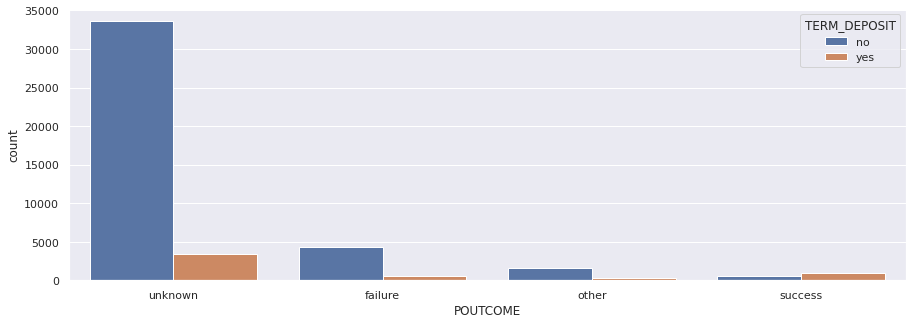

In [46]:
plt.figure(figsize = (15, 5))
sns.countplot(x="POUTCOME", hue='TERM_DEPOSIT', data=df);

<Figure size 2160x2160 with 0 Axes>

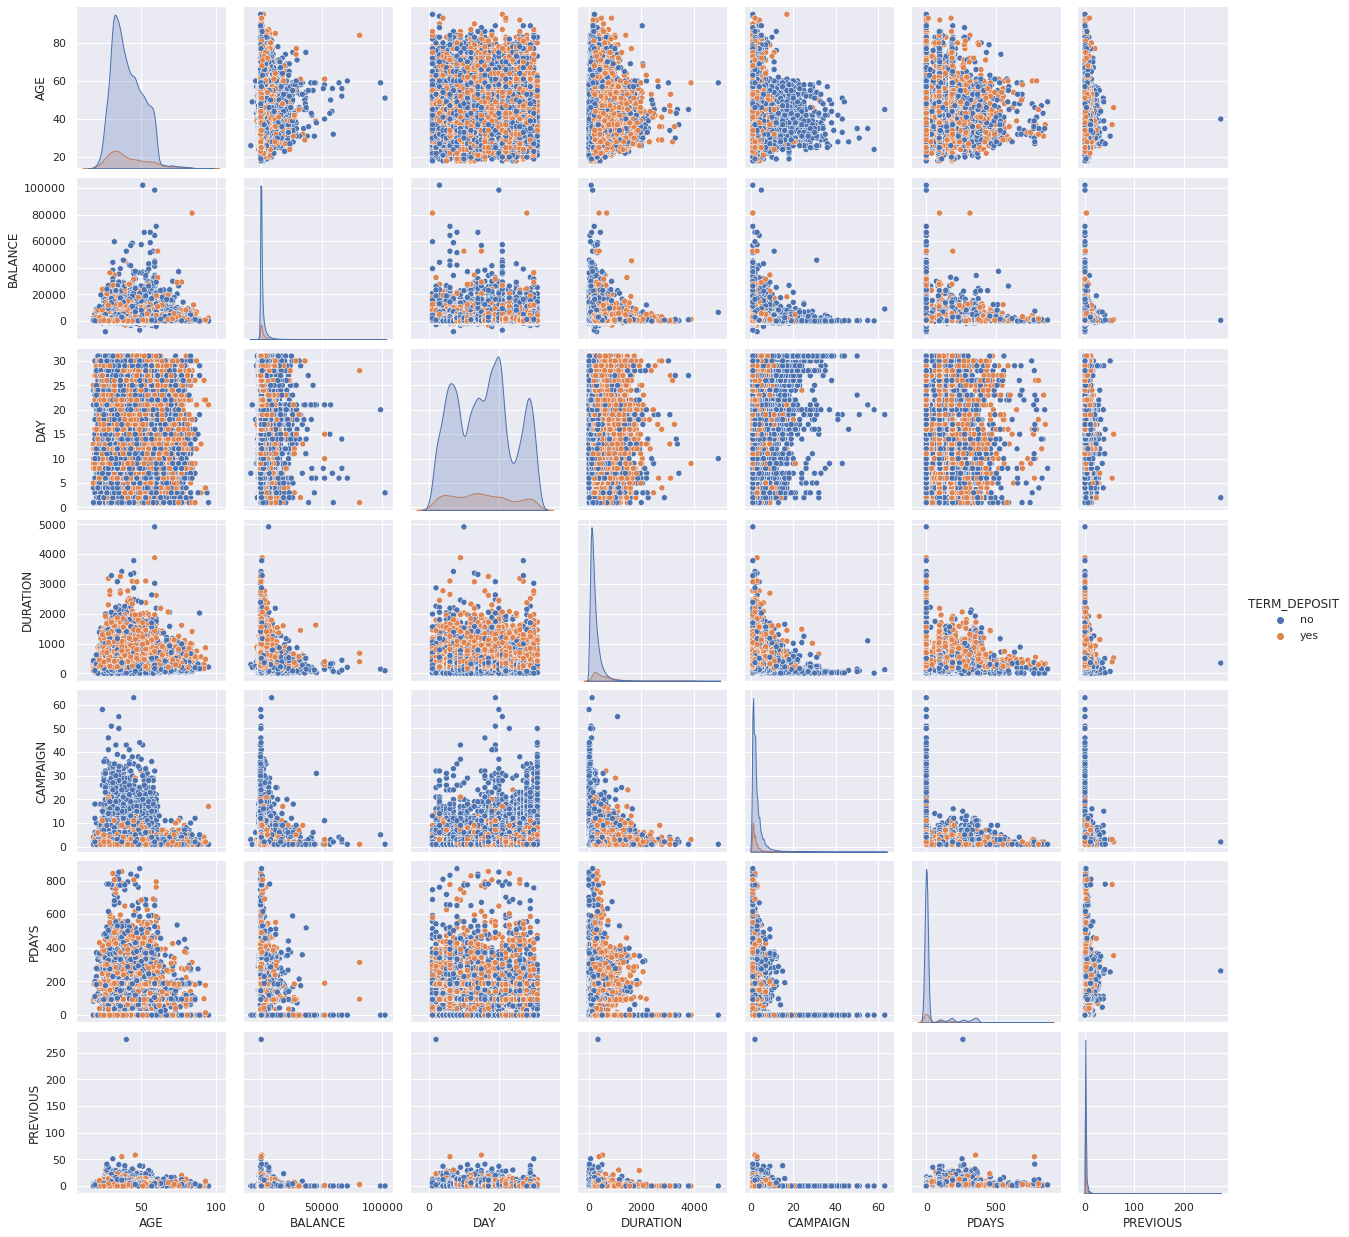

In [47]:
plt.figure(figsize = (30, 30))
sns.pairplot(df, hue='TERM_DEPOSIT')

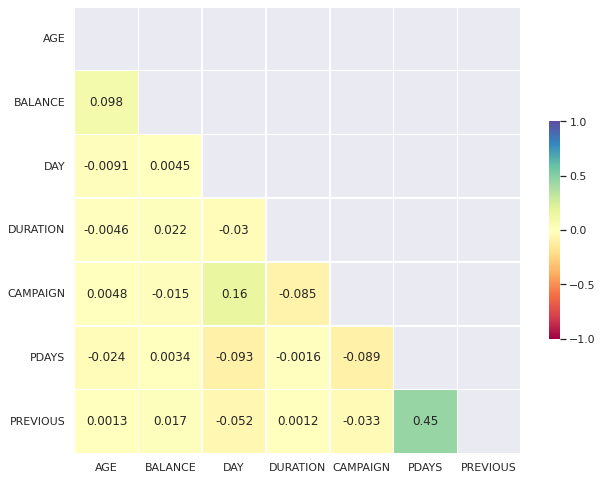

In [48]:
#correlation matrix
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(10, 10)) 
heatmap = sns.heatmap(corr, 
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'Spectral',
                      cbar_kws = {'shrink': .4, 
                                "ticks" : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})

#add the column names as labels
ax.set_yticklabels(corr.columns, rotation = 0)
ax.set_xticklabels(corr.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True});

# Data Prep & Start H2O

In [49]:
#start H2O cluster
! pip install h2o
import h2o

#initialize
h2o.init()

     |████████████████████████████████| 175.8 MB 13 kB/s 
  Created wheel for h2o: filename=h2o-3.34.0.3-py2.py3-none-any.whl size=175832480 sha256=f6a554aede9ffdd319f0805501a976b02ca7b7b82a984096ad26db7571b42e20
  Stored in directory: /root/.cache/pip/wheels/2a/52/cf/01f6938288f0731963463ff72510db67f9f3076f801038b2f7
Successfully built h2o
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpp8lq29u0
  JVM stdout: /tmp/tmpp8lq29u0/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpp8lq29u0/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_unknownUser_k4vgau
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [50]:
#convert pandas df into h2o frame
h2o_df = h2o.H2OFrame(df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [51]:
#preview
h2o_df

AGE,JOB,MARITAL,EDUCATION,DEFAULT,BALANCE,HOUSING,LOAN,CONTACT,DAY,MONTH,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,TERM_DEPOSIT
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [52]:
#statistics
h2o_df.describe()

#enum ~ categorical data

Rows:45211
Cols:17




,AGE,JOB,MARITAL,EDUCATION,DEFAULT,BALANCE,HOUSING,LOAN,CONTACT,DAY,MONTH,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,TERM_DEPOSIT
type,int,enum,enum,enum,enum,int,enum,enum,enum,int,enum,int,int,int,int,enum,enum
mins,18.0,,,,,-8019.0,,,,1.0,,0.0,1.0,-1.0,0.0,,
mean,40.93621021432807,,,,,1362.2720576850802,,,,15.806418791886923,,258.16307978146915,2.7638406582468997,40.19782796222158,0.5803233726305561,,
maxs,95.0,,,,,102127.0,,,,31.0,,4918.0,63.0,871.0,275.0,,
sigma,10.618762040975398,,,,,3044.7658291685216,,,,8.32247615304459,,257.52781226517124,3.0980208832791805,100.12874599059822,2.303441044931215,,
zeros,0,,,,,3514,,,,0,,3,0,0,36954,,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,58.0,management,married,tertiary,no,2143.0,yes,no,unknown,5.0,may,261.0,1.0,-1.0,0.0,unknown,no
1,44.0,technician,single,secondary,no,29.0,yes,no,unknown,5.0,may,151.0,1.0,-1.0,0.0,unknown,no
2,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5.0,may,76.0,1.0,-1.0,0.0,unknown,no


## Train Test Split

In [53]:
#split train and test sets
train, test = h2o_df.split_frame(ratios=[.75], seed=121)

#define X and y
X = train.columns
y = 'TERM_DEPOSIT'
X.remove(y)

In [54]:
#for binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

In [55]:
X

['AGE',
 'JOB',
 'MARITAL',
 'EDUCATION',
 'DEFAULT',
 'BALANCE',
 'HOUSING',
 'LOAN',
 'CONTACT',
 'DAY',
 'MONTH',
 'DURATION',
 'CAMPAIGN',
 'PDAYS',
 'PREVIOUS',
 'POUTCOME']

In [56]:
y

'TERM_DEPOSIT'

# Run H2O AutoML

In [57]:
#check class distribution
df.TERM_DEPOSIT.value_counts()

no     39922
yes     5289
Name: TERM_DEPOSIT, dtype: int64

In [58]:
from h2o.automl import H2OAutoML

#initialize
aml = H2OAutoML(max_runtime_secs=3600,   #keep runtime at max
                balance_classes=True,
                stopping_metric='AUC',
                seed=121) 

In [59]:
#train
%time 
aml.train(x=X, 
          y=y,
          training_frame=train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_3_AutoML_1_20211009_213728

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.032441974956864614
RMSE: 0.18011655936327625
LogLoss: 0.11526178078577111
Null degrees of freedom: 10042
Residual degrees of freedom: 10026
Null deviance: 7212.569431635384
Residual deviance: 2315.1481288629993
AIC: 2349.1481288629993
AUC: 0.9858576068476149
AUCPR: 0.9190430796546831
Gini: 0.9717152136952298

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43795222702334957: 


,,no,yes,Error,Rate
0,no,8675.0,202.0,0.0228,(202.0/8877.0)
1,yes,187.0,979.0,0.1604,(187.0/1166.0)
2,Total,8862.0,1181.0,0.0387,(389.0/10043.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.437952,0.834256,173.0
1,max f2,0.327861,0.870096,210.0
2,max f0point5,0.552793,0.871579,133.0
3,max accuracy,0.525425,0.961565,143.0
4,max precision,0.991382,1.000000,0.0
5,max recall,0.015003,1.000000,373.0
6,max specificity,0.991382,1.000000,0.0
7,max absolute_mcc,0.437952,0.812350,173.0
8,max min_per_class_accuracy,0.265963,0.937393,230.0
9,max mean_per_class_accuracy,0.225711,0.939457,246.0



Gains/Lift Table: Avg response rate: 11.61 %, avg score: 12.21 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010057,0.928623,8.613208,8.613208,1.000000,0.966437,1.000000,0.966437,0.086621,0.086621,761.320755,761.320755,0.086621
1,2,0.020014,0.865439,8.613208,8.613208,1.000000,0.899672,1.000000,0.933220,0.085763,0.172384,761.320755,761.320755,0.172384
2,3,0.030071,0.804517,8.613208,8.613208,1.000000,0.835532,1.000000,0.900550,0.086621,0.259005,761.320755,761.320755,0.259005
3,4,0.040028,0.762739,8.354811,8.548930,0.970000,0.782982,0.992537,0.871304,0.083190,0.342196,735.481132,754.892988,0.341858
4,5,0.050085,0.719132,8.442649,8.527589,0.980198,0.740248,0.990060,0.844989,0.084906,0.427101,744.264898,752.758918,0.426538
5,6,0.100070,0.517678,6.725851,7.627617,0.780876,0.616715,0.885572,0.730965,0.336192,0.763293,572.585131,662.761663,0.750338
6,7,0.150055,0.314770,3.088401,6.115549,0.358566,0.408712,0.710020,0.623619,0.154374,0.917667,208.840111,511.554882,0.868439
7,8,0.200040,0.176209,1.063783,4.853236,0.123506,0.236602,0.563464,0.526913,0.053173,0.970840,6.378261,385.323591,0.872046
8,9,0.300010,0.057259,0.223051,3.310353,0.025896,0.104022,0.384335,0.385996,0.022298,0.993139,-77.694881,231.035325,0.784172
9,10,0.399980,0.022952,0.051473,2.495836,0.005976,0.036964,0.289768,0.298760,0.005146,0.998285,-94.852665,149.583609,0.676892




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.061180819490294844
RMSE: 0.2473475681915932
LogLoss: 0.1937001277480321
Null degrees of freedom: 33929
Residual degrees of freedom: 33913
Null deviance: 24432.034038796606
Residual deviance: 13144.490668981458
AIC: 13178.490668981458
AUC: 0.9364834032574554
AUCPR: 0.633859167565267
Gini: 0.8729668065149108

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30233418023320024: 


,,no,yes,Error,Rate
0,no,27642.0,2333.0,0.0778,(2333.0/29975.0)
1,yes,1050.0,2905.0,0.2655,(1050.0/3955.0)
2,Total,28692.0,5238.0,0.0997,(3383.0/33930.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.302334,0.632003,219.0
1,max f2,0.121290,0.741556,294.0
2,max f0point5,0.460497,0.615757,156.0
3,max accuracy,0.460497,0.910640,156.0
4,max precision,0.985539,1.000000,0.0
5,max recall,0.000420,1.000000,399.0
6,max specificity,0.985539,1.000000,0.0
7,max absolute_mcc,0.240829,0.585294,241.0
8,max min_per_class_accuracy,0.158192,0.867523,275.0
9,max mean_per_class_accuracy,0.094576,0.873906,309.0



Gains/Lift Table: Avg response rate: 11.66 %, avg score: 11.66 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010021,0.839210,7.216465,7.216465,0.841176,0.881782,0.841176,0.881782,0.072314,0.072314,621.646464,621.646464,0.070512
1,2,0.020012,0.772653,6.453241,6.835415,0.752212,0.804606,0.796760,0.843251,0.064475,0.136789,545.324055,583.541461,0.132185
2,3,0.030003,0.716010,5.744649,6.472183,0.669617,0.742201,0.754420,0.809601,0.057396,0.194185,474.464943,547.218338,0.185844
3,4,0.040024,0.673083,5.652056,6.266850,0.658824,0.693807,0.730486,0.780610,0.056637,0.250822,465.205622,526.684963,0.238612
4,5,0.050015,0.633886,5.567502,6.127145,0.648968,0.651826,0.714202,0.754883,0.055626,0.306448,456.750165,512.714488,0.290267
5,6,0.100000,0.464871,4.764995,5.446271,0.555425,0.549668,0.634836,0.652306,0.238180,0.544627,376.499475,444.627054,0.503293
6,7,0.150015,0.312704,3.533725,4.808630,0.411903,0.388316,0.560511,0.564292,0.176738,0.721365,253.372464,380.863000,0.646737
7,8,0.200000,0.188959,2.387556,4.203540,0.278302,0.247295,0.489979,0.485066,0.119343,0.840708,138.755576,320.353982,0.725245
8,9,0.300000,0.067011,1.084703,3.163928,0.126437,0.117232,0.368799,0.362455,0.108470,0.949178,8.470291,216.392752,0.734833
9,10,0.400000,0.028413,0.313527,2.451327,0.036546,0.044485,0.285735,0.282962,0.031353,0.980531,-68.647282,145.132743,0.657128


# AutoML Leaderboard and Ensemble Exploration

In [60]:
#view leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows) #show all the rows

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_3_AutoML_1_20211009_213728,0.936483,0.1937,0.633859,0.171659,0.247348,0.0611808
StackedEnsemble_AllModels_4_AutoML_1_20211009_213728,0.936288,0.193922,0.633446,0.171714,0.247418,0.0612156
StackedEnsemble_AllModels_2_AutoML_1_20211009_213728,0.935364,0.194957,0.632823,0.164019,0.247905,0.0614568
StackedEnsemble_BestOfFamily_4_AutoML_1_20211009_213728,0.935223,0.194872,0.629056,0.165972,0.248024,0.0615161
StackedEnsemble_BestOfFamily_3_AutoML_1_20211009_213728,0.935152,0.195166,0.631565,0.157271,0.24801,0.0615088
StackedEnsemble_AllModels_6_AutoML_1_20211009_213728,0.934758,0.197666,0.625186,0.158868,0.247765,0.0613877
XGBoost_grid_1_AutoML_1_20211009_213728_model_3,0.933926,0.199105,0.618722,0.158982,0.250656,0.0628282
StackedEnsemble_AllModels_1_AutoML_1_20211009_213728,0.933712,0.196668,0.628765,0.152201,0.248912,0.0619571
StackedEnsemble_BestOfFamily_6_AutoML_1_20211009_213728,0.933509,0.197076,0.615235,0.164198,0.249456,0.0622281
StackedEnsemble_BestOfFamily_2_AutoML_1_20211009_213728,0.933279,0.197285,0.62533,0.156222,0.249342,0.0621715


In [61]:
#look at best model
se = aml.leader
metalearner = h2o.get_model(se.metalearner()['name'])

/usr/local/lib/python3.7/dist-packages/h2o/estimators/stackedensemble.py:929: H2ODeprecationWarning: The usage of stacked_ensemble.metalearner()['name'] will be deprecated. Metalearner now returns the metalearner object. If you need to get the 'name' please use stacked_ensemble.metalearner().model_id
  H2ODeprecationWarning


In [62]:
#look at important variables
metalearner.varimp()

[('DRF_1_AutoML_1_20211009_213728',
  0.6612058877944946,
  1.0,
  0.2319483004390333),
 ('XGBoost_3_AutoML_1_20211009_213728',
  0.4469129741191864,
  0.6759059203327734,
  0.15677522947786746),
 ('XGBoost_grid_1_AutoML_1_20211009_213728_model_3',
  0.2941346764564514,
  0.44484582168129394,
  0.10318123229638142),
 ('GBM_grid_1_AutoML_1_20211009_213728_model_7',
  0.25648263096809387,
  0.38790131138065376,
  0.08997304991281489),
 ('GBM_grid_1_AutoML_1_20211009_213728_model_4',
  0.22654567658901215,
  0.3426250140401403,
  0.07947128969451046),
 ('XGBoost_grid_1_AutoML_1_20211009_213728_model_4',
  0.18386073410511017,
  0.27806880957819724,
  0.06449758778676803),
 ('DeepLearning_grid_1_AutoML_1_20211009_213728_model_1',
  0.15178710222244263,
  0.22956102633741013,
  0.05324628990600244),
 ('XGBoost_grid_1_AutoML_1_20211009_213728_model_1',
  0.1515122950077057,
  0.22914541114128176,
  0.05314988866762384),
 ('GBM_grid_1_AutoML_1_20211009_213728_model_5',
  0.11107441037893295,


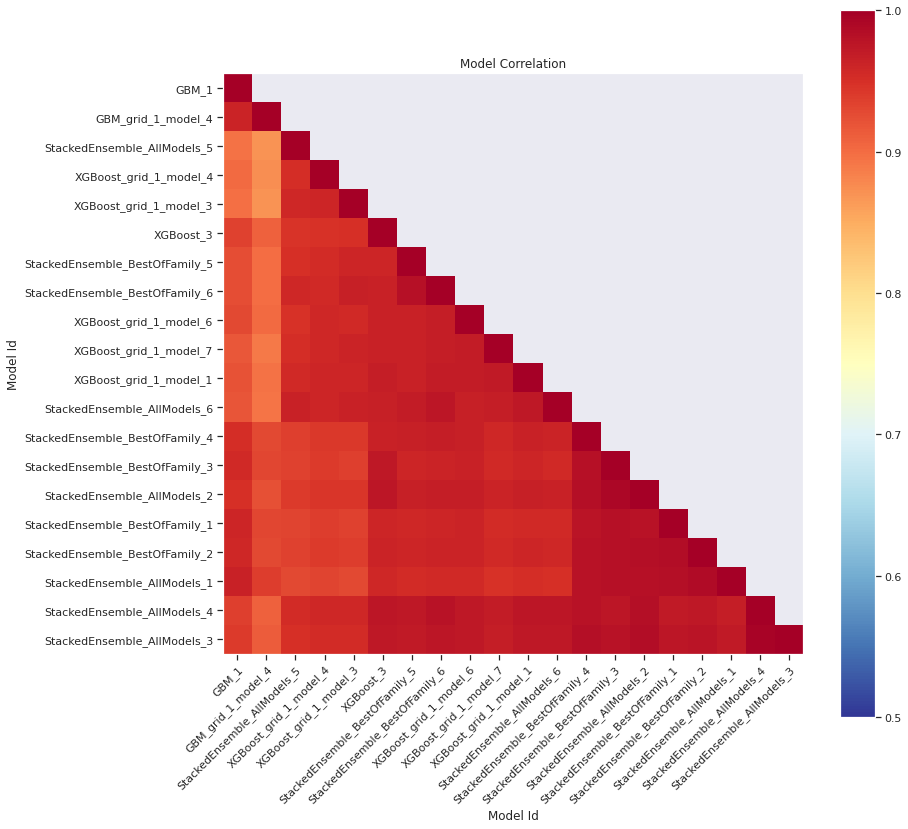

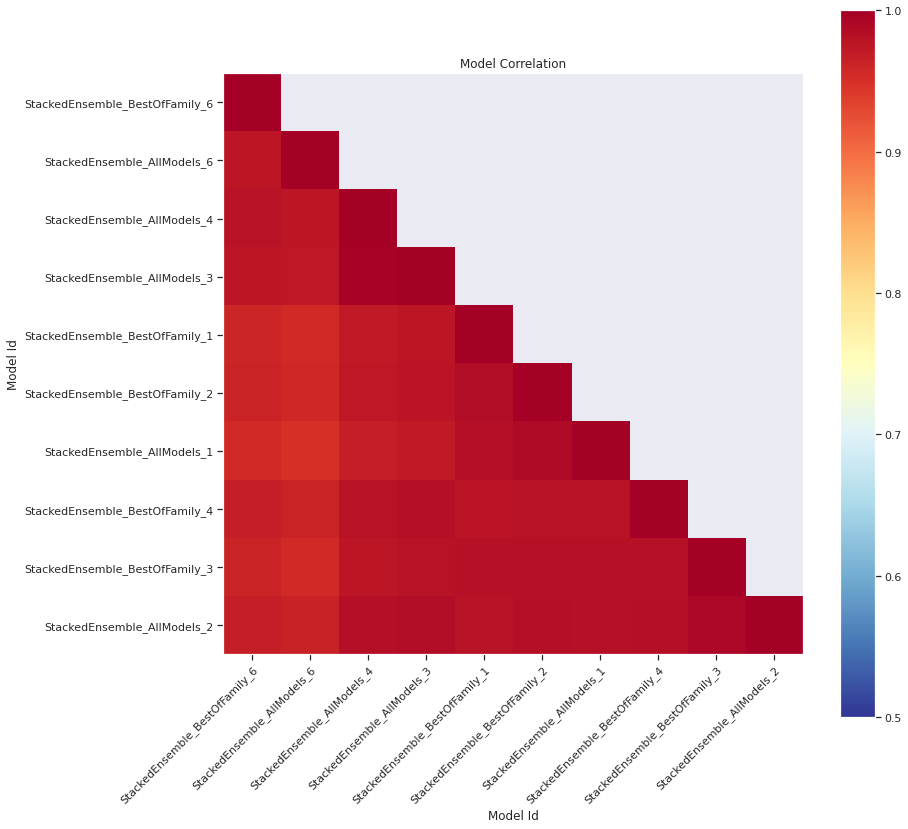

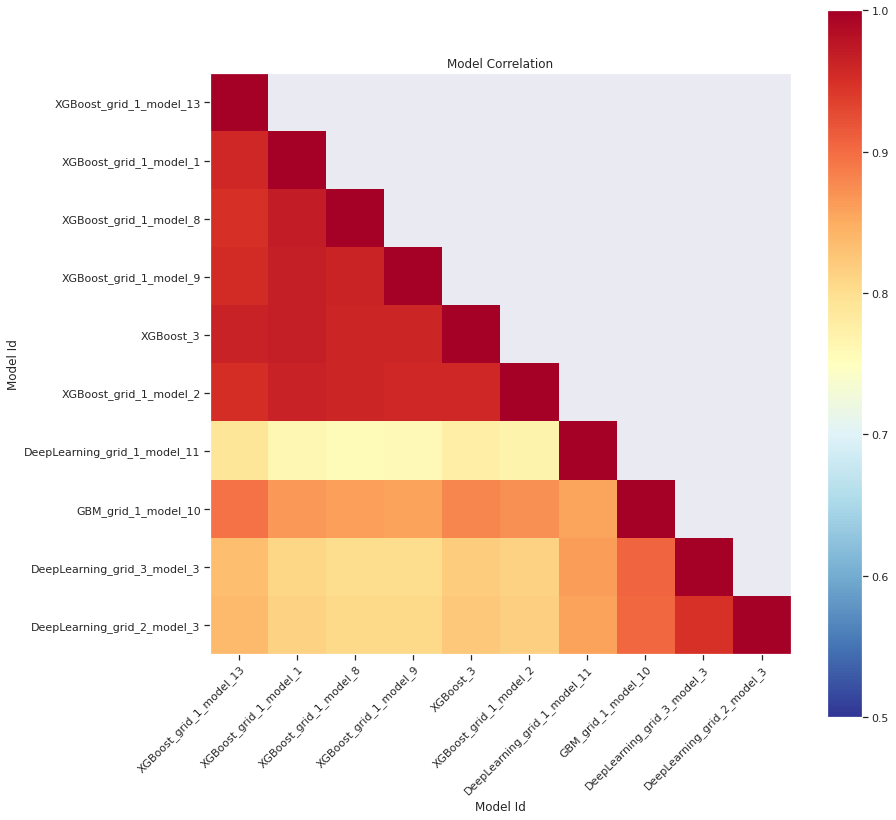

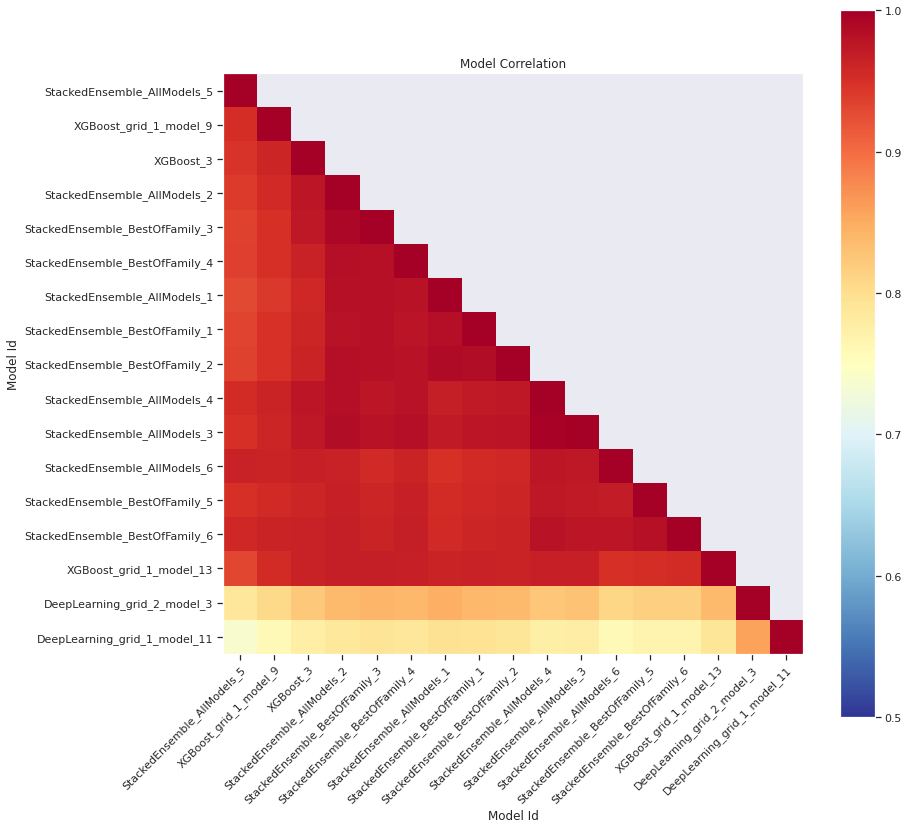

In [63]:
mc_plot = aml.model_correlation_heatmap(test)

# or if some subset of the models is needed a slice of leaderboard can be used, e.g., using MAE as the sorting metric
mc_plot = h2o.model_correlation_heatmap(aml.leaderboard.sort("rmse").head(10), test)

# or even extended leaderboard can be used
mc_plot = h2o.model_correlation_heatmap(h2o.automl.get_leaderboard(aml, extra_columns="training_time_ms").sort("training_time_ms").head(10), test)

# also more complicated queries on leaderboard can be used, e.g., model correlation between 5 fastest models to train and Stacked Ensembles
leaderboard = h2o.automl.get_leaderboard(aml, extra_columns="training_time_ms").sort("training_time_ms")
mc_plot = h2o.model_correlation_heatmap(leaderboard.head(5).rbind(leaderboard[leaderboard["model_id"].grep("StackedEnsemble", output_logical=True)]), test)

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_3_AutoML_1_20211009_213728


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27925134744774494: 


,,no,yes,Error,Rate
0,no,9085.0,862.0,0.0867,(862.0/9947.0)
1,yes,281.0,1053.0,0.2106,(281.0/1334.0)
2,Total,9366.0,1915.0,0.1013,(1143.0/11281.0)


# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

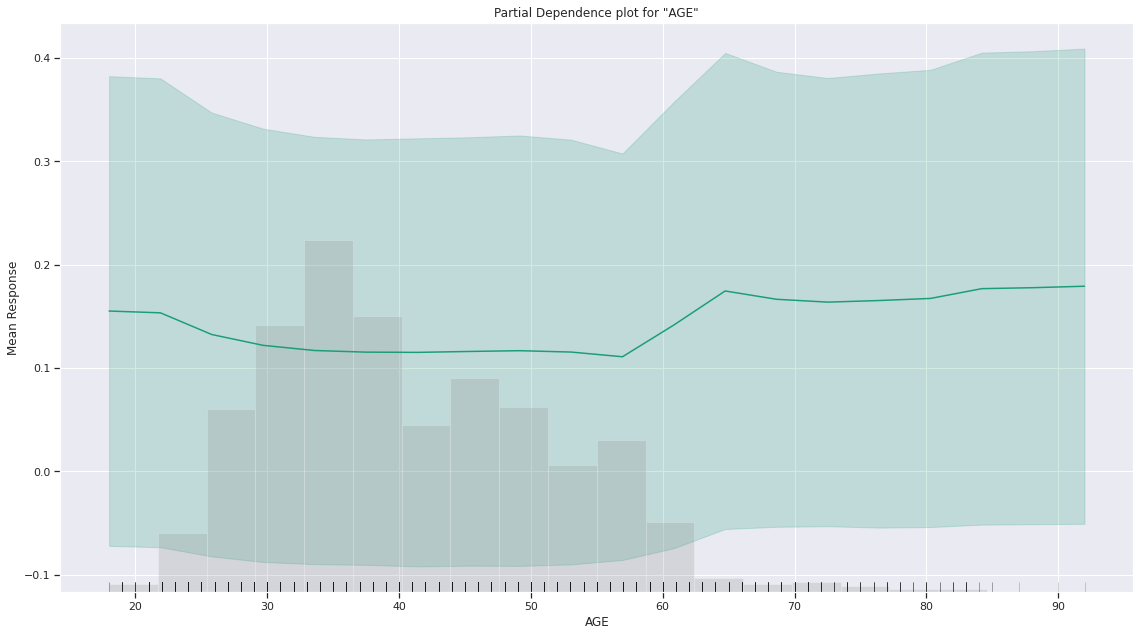

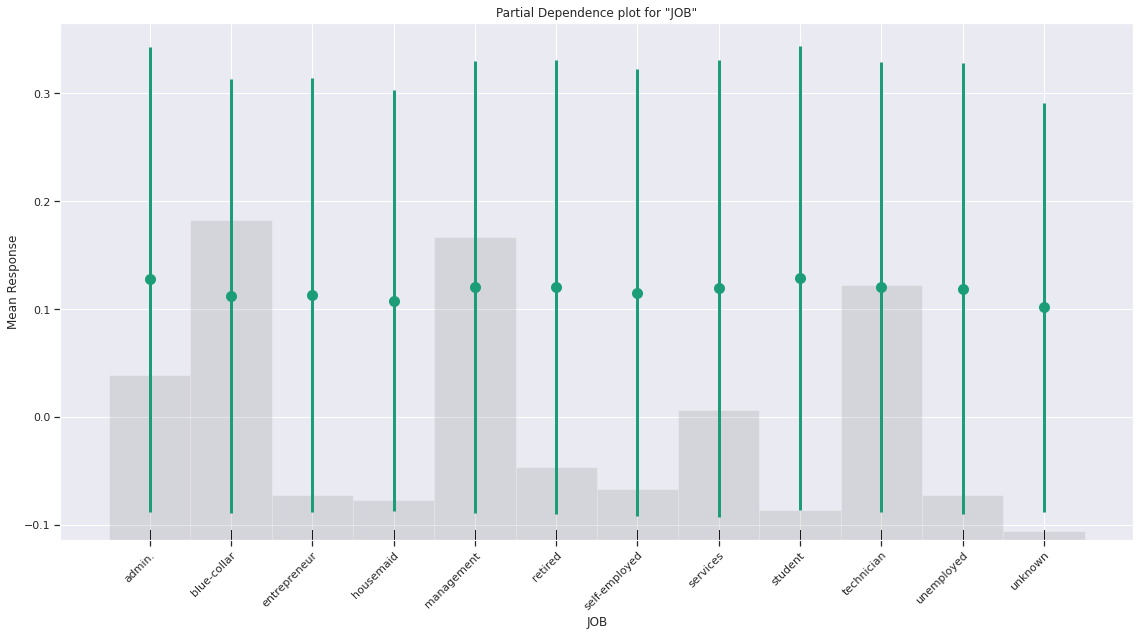

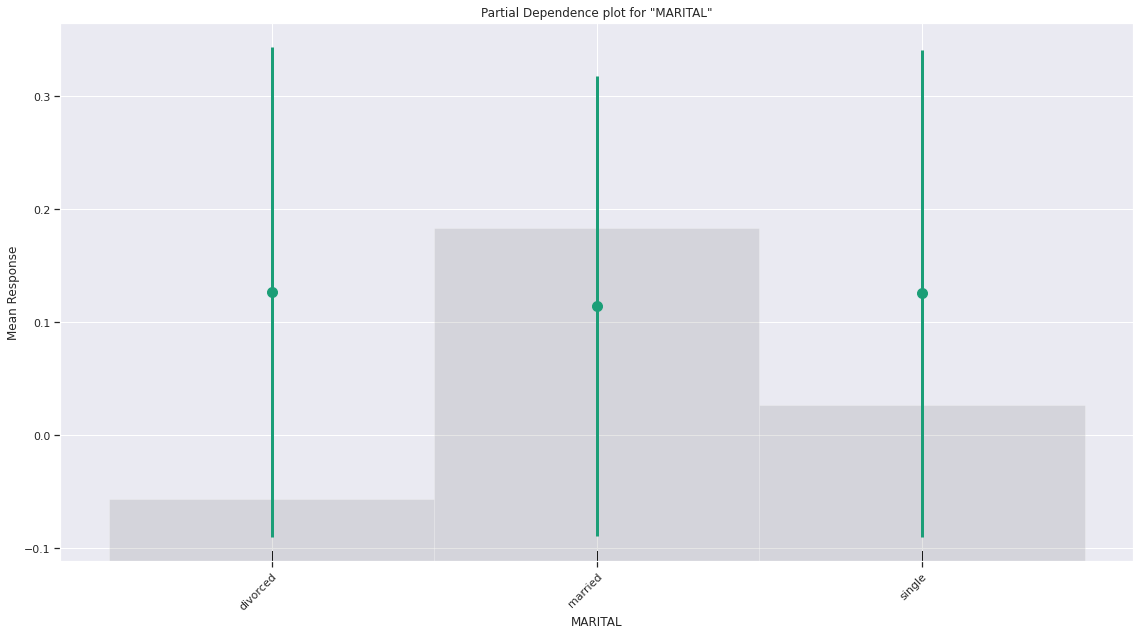

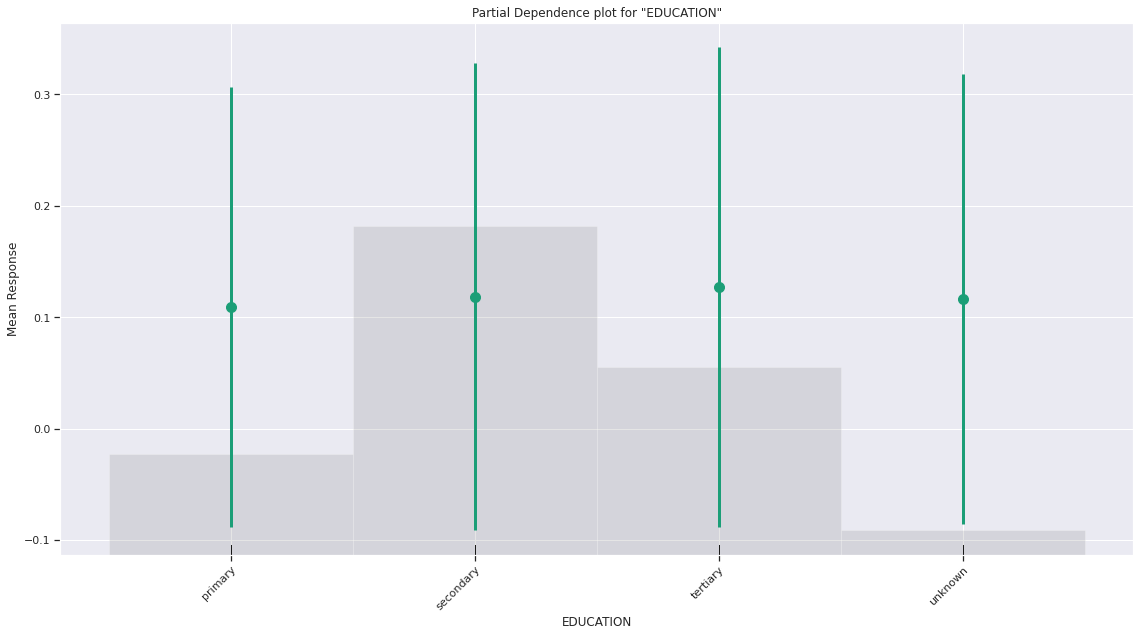

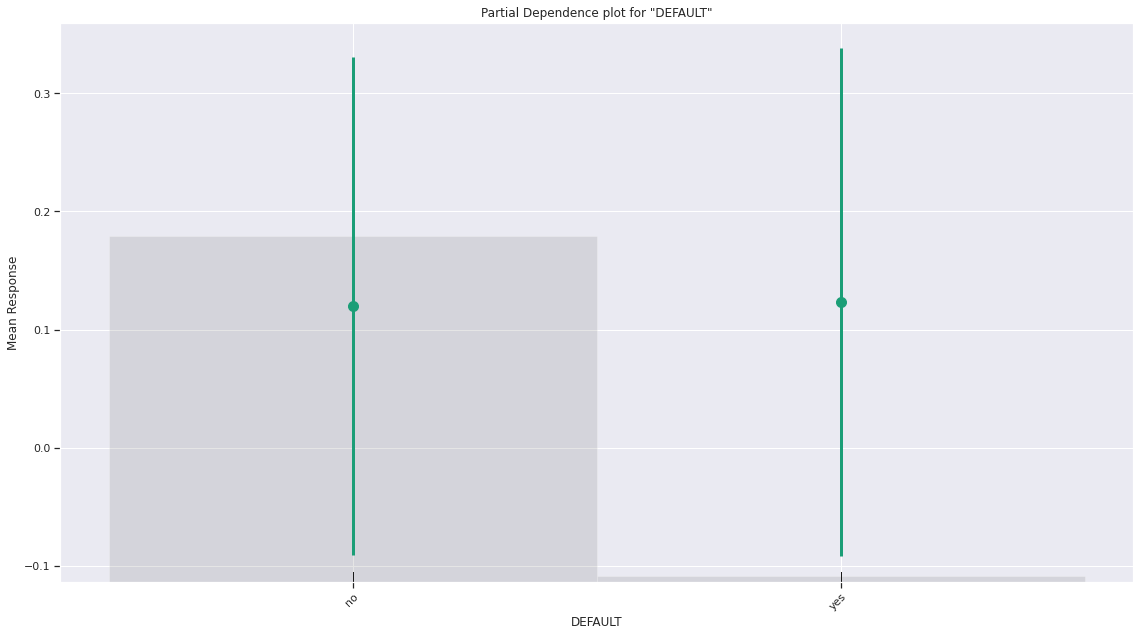

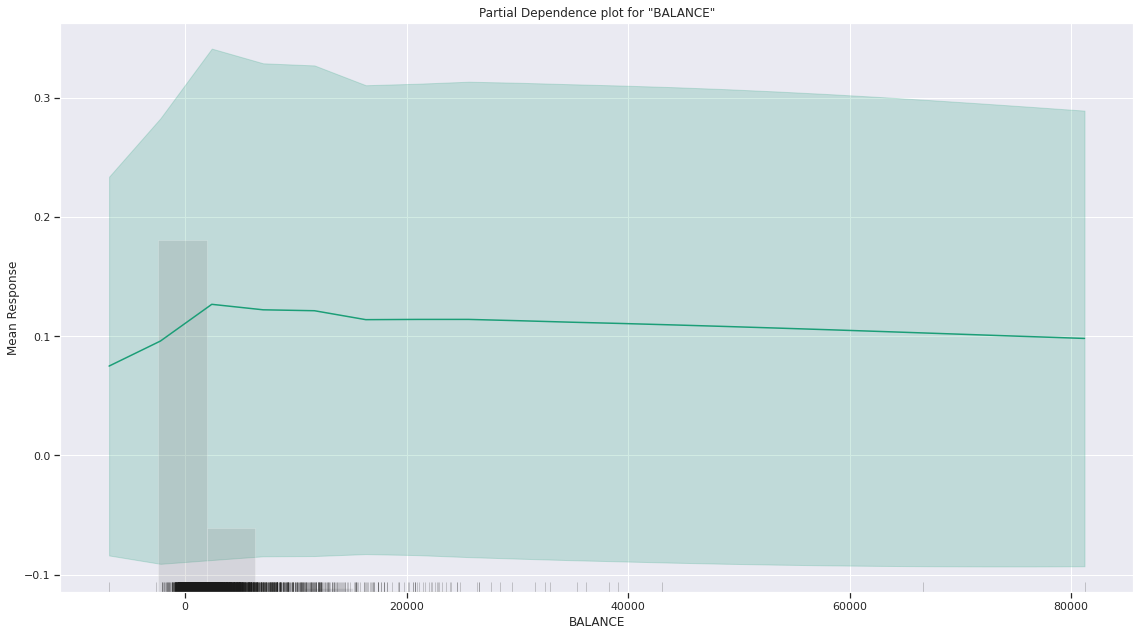

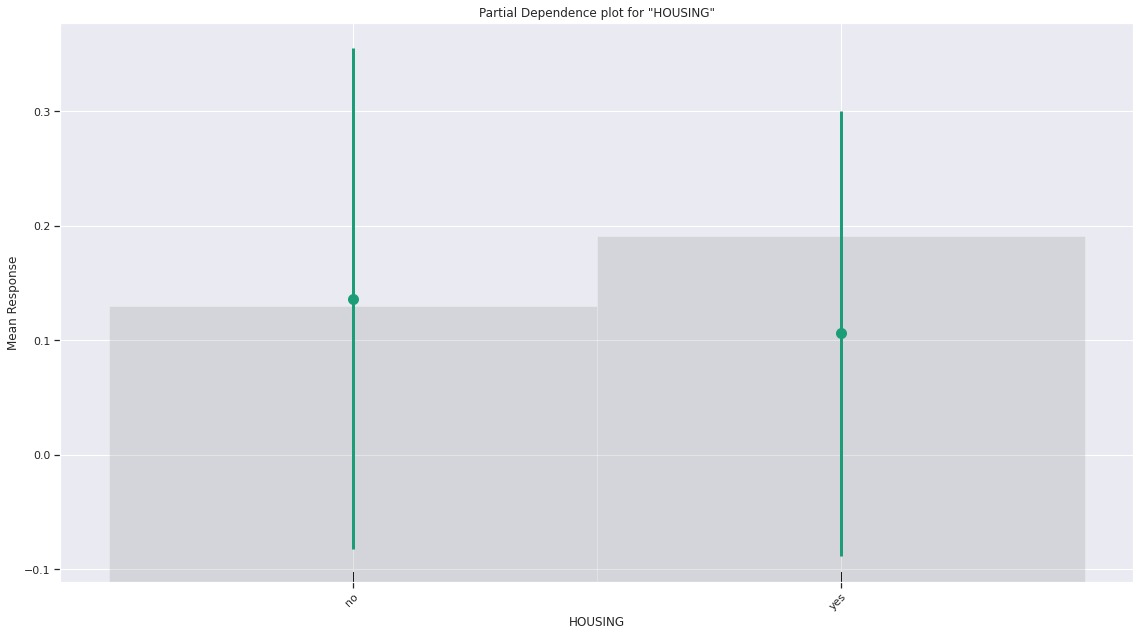

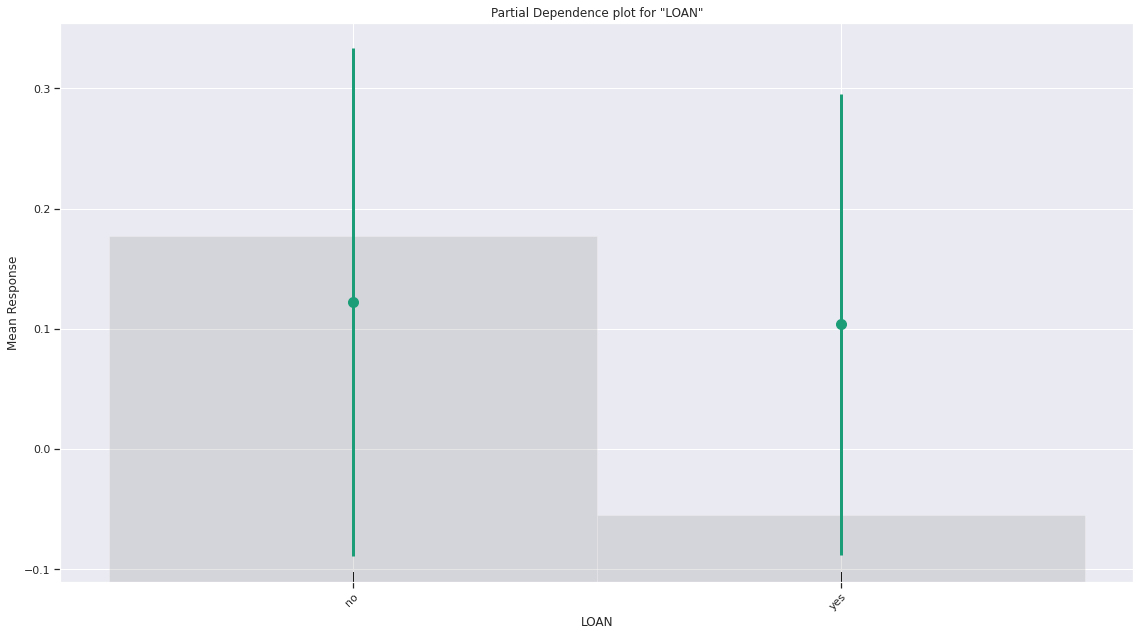

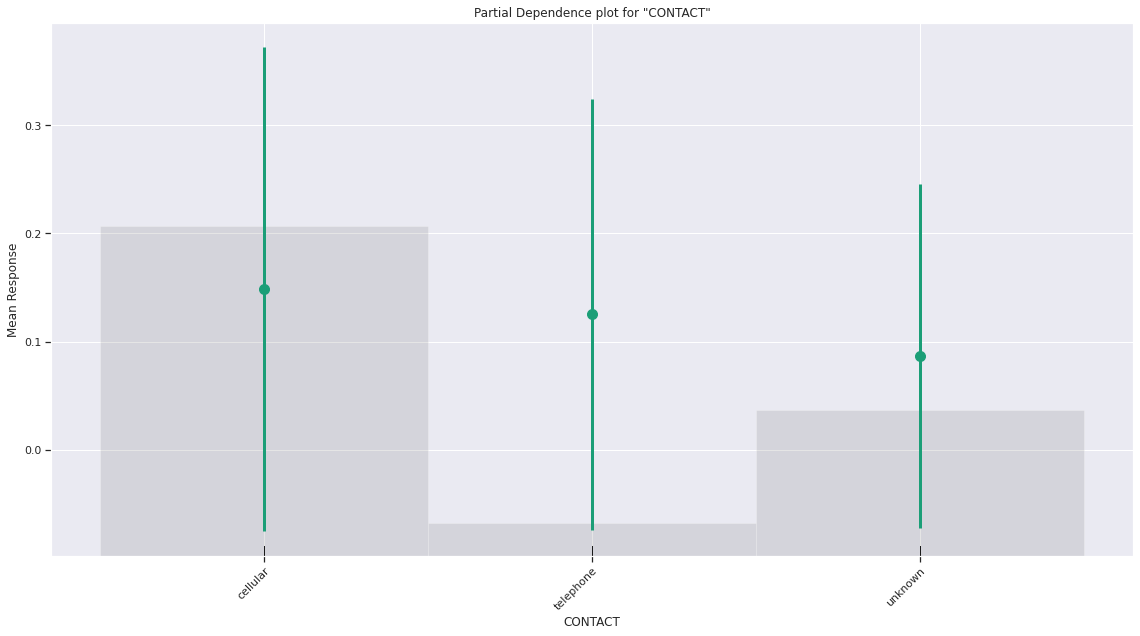

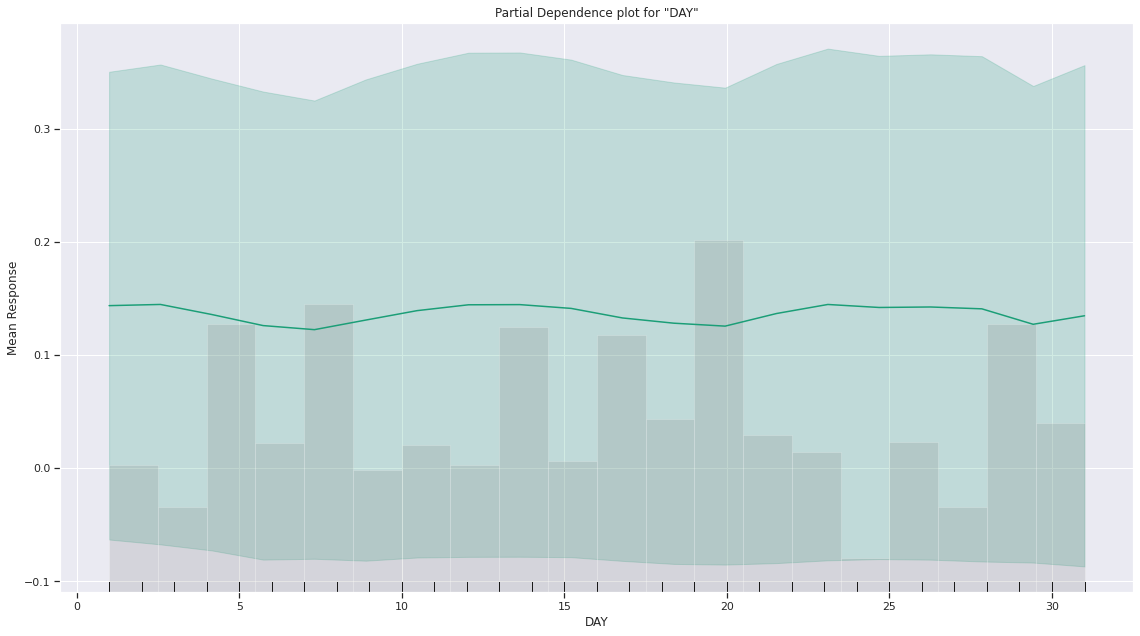

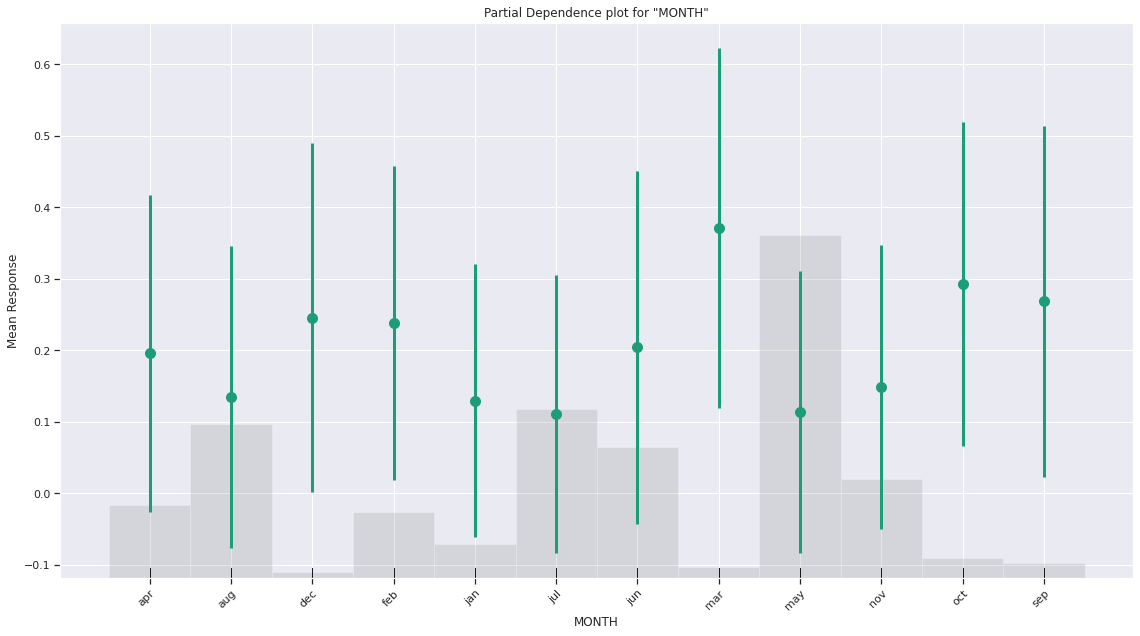

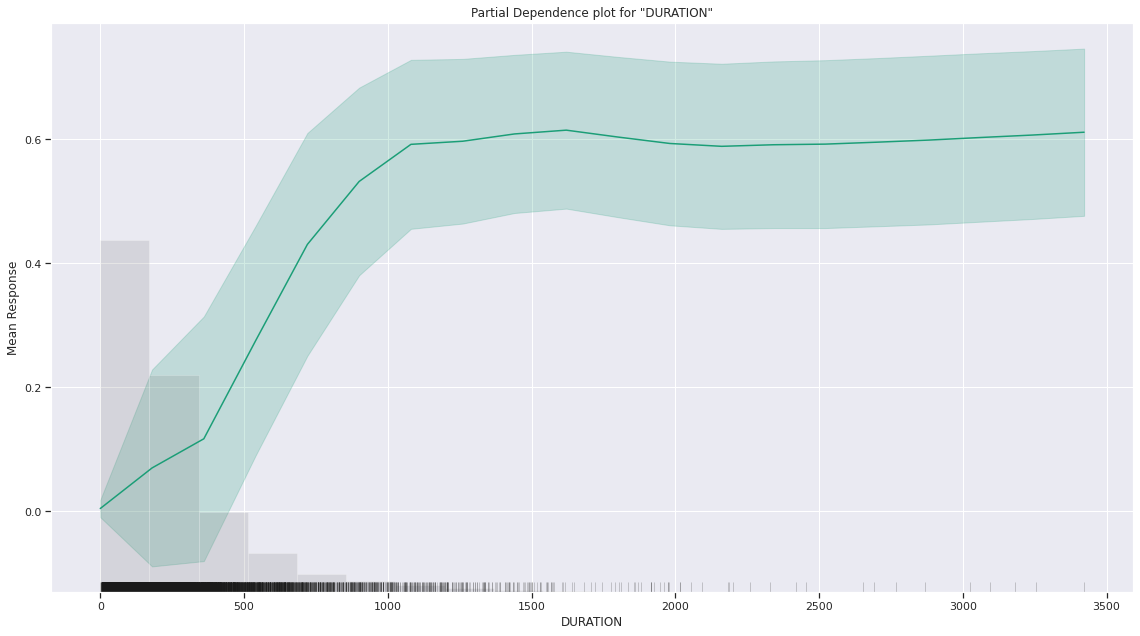

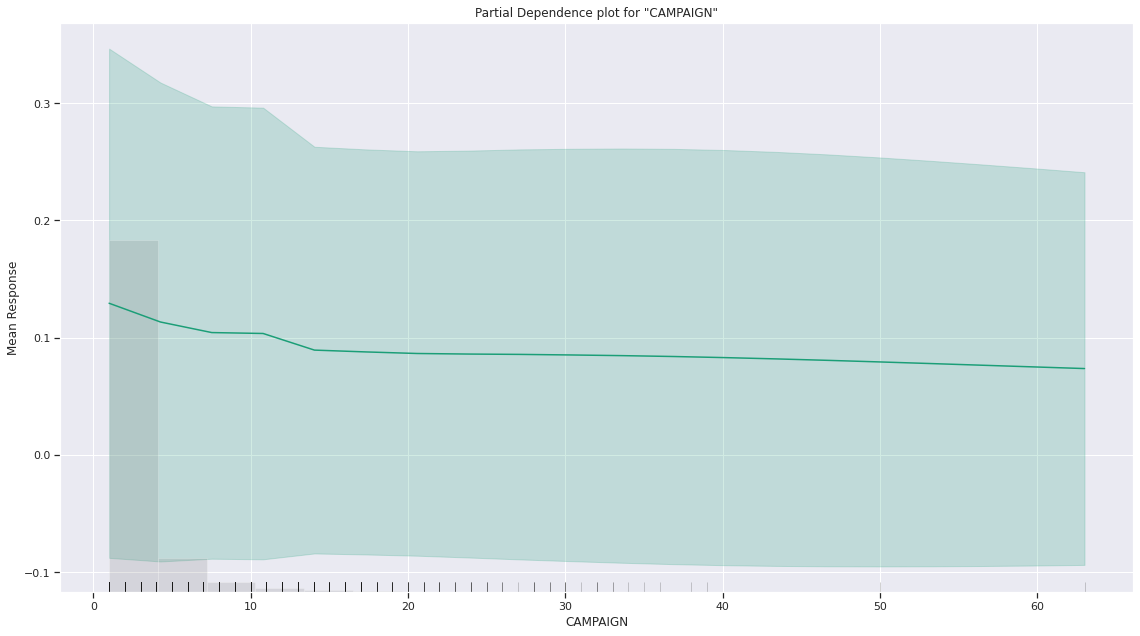

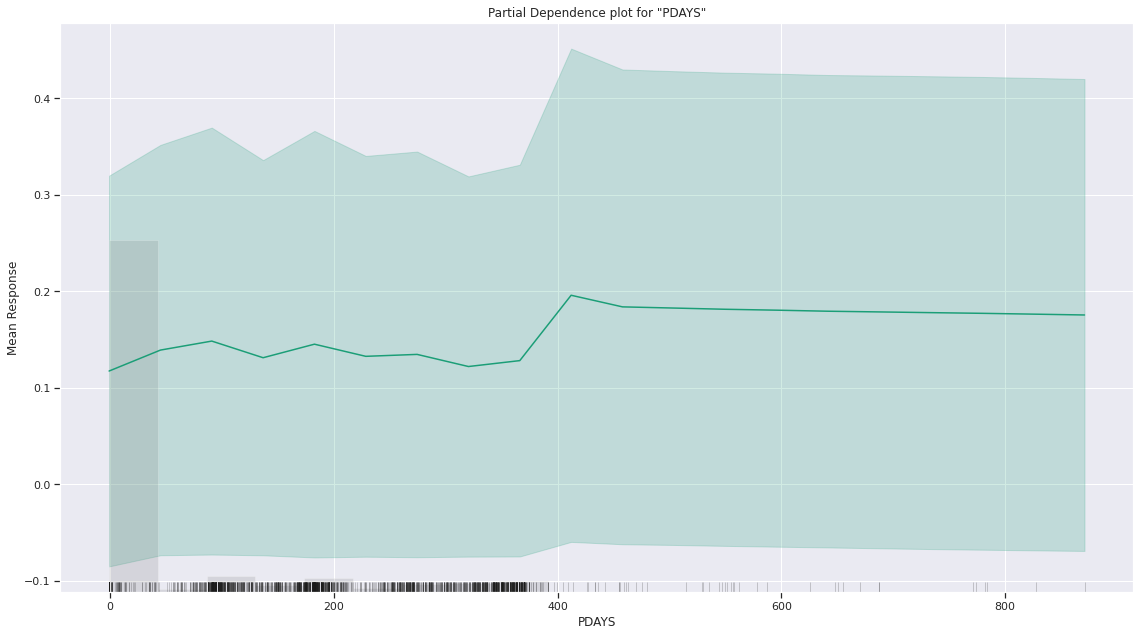

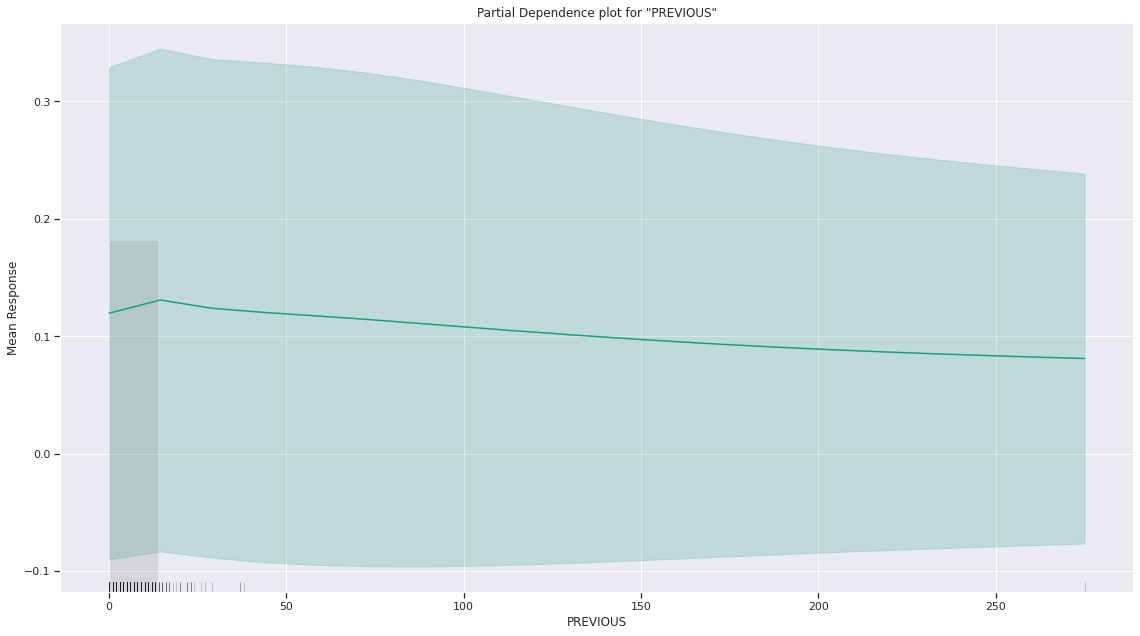

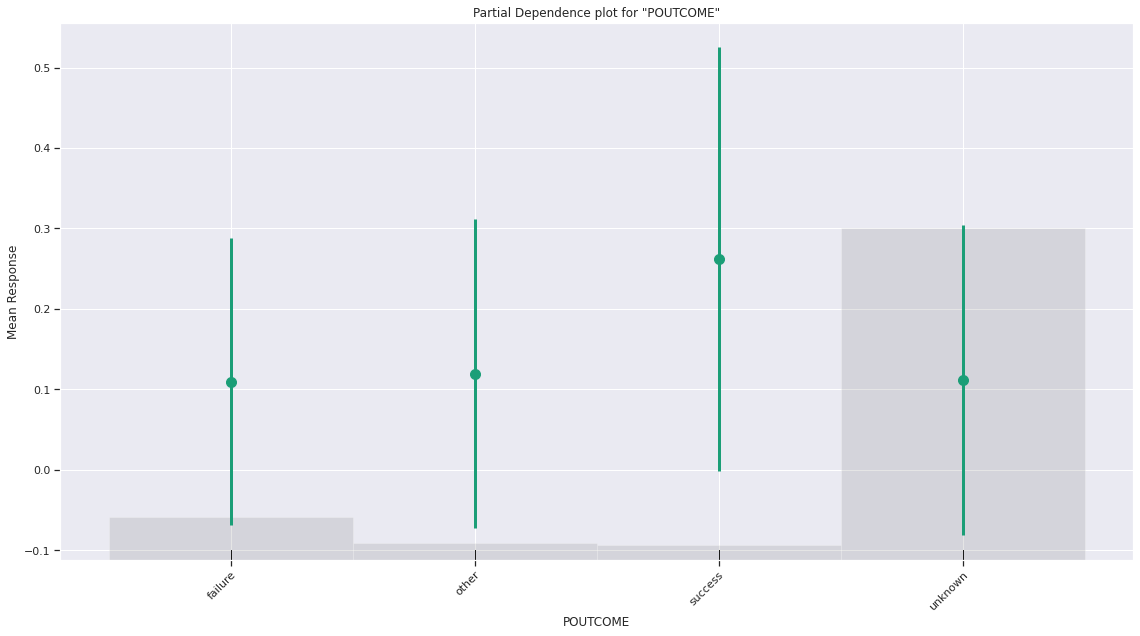

In [66]:
#explain a single H2O model (e.g. leader model from AutoML)
exm = aml.leader.explain(test)

# Base Learner Model Exploration

In [67]:
#import top performing base learner
base_model = h2o.get_model('DRF_1_AutoML_1_20211009_213728')

In [68]:
#evaluate the base learner on the test set
base_model.model_performance(test)


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.08155979528267593
RMSE: 0.28558675614018925
LogLoss: 0.26612134582261743
Mean Per-Class Error: 0.12920544101127285
AUC: 0.9316454043009661
AUCPR: 0.5974966481711743
Gini: 0.8632908086019322

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.07411142578789318: 


,,no,yes,Error,Rate
0,no,8921.0,1026.0,0.1031,(1026.0/9947.0)
1,yes,255.0,1079.0,0.1912,(255.0/1334.0)
2,Total,9176.0,2105.0,0.1136,(1281.0/11281.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.074111,0.627508,290.0
1,max f2,0.049227,0.740976,315.0
2,max f0point5,0.151771,0.592509,219.0
3,max accuracy,0.151771,0.904175,219.0
4,max precision,1.000000,1.000000,0.0
5,max recall,0.000002,1.000000,399.0
6,max specificity,1.000000,1.000000,0.0
7,max absolute_mcc,0.074111,0.584912,290.0
8,max min_per_class_accuracy,0.051062,0.866090,313.0
9,max mean_per_class_accuracy,0.035084,0.870795,334.0



Gains/Lift Table: Avg response rate: 11.83 %, avg score:  4.82 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010726,0.493167,6.289975,6.289975,0.743802,0.634845,0.743802,0.634845,0.067466,0.067466,528.997485,528.997485,0.064350
1,2,0.020034,0.399188,5.959834,6.136591,0.704762,0.445199,0.725664,0.546735,0.055472,0.122939,495.983437,513.659100,0.116705
2,3,0.030051,0.341804,5.912082,6.061755,0.699115,0.367124,0.716814,0.486865,0.059220,0.182159,491.208157,506.175452,0.172508
3,4,0.040067,0.302792,5.537899,5.930791,0.654867,0.322471,0.701327,0.445766,0.055472,0.237631,453.789919,493.079069,0.224059
4,5,0.050173,0.270375,5.118421,5.767169,0.605263,0.284801,0.681979,0.413346,0.051724,0.289355,411.842105,476.716854,0.271259
5,6,0.100080,0.161590,4.506139,5.138329,0.532860,0.209851,0.607617,0.311869,0.224888,0.514243,350.613947,413.832942,0.469707
6,7,0.150075,0.104767,3.733464,4.670318,0.441489,0.131953,0.552274,0.251932,0.186657,0.700900,273.346438,367.031768,0.624696
7,8,0.200071,0.063351,2.638915,4.162692,0.312057,0.083101,0.492246,0.209743,0.131934,0.832834,163.891459,316.269192,0.717623
8,9,0.300062,0.023126,1.147028,3.157768,0.135638,0.039673,0.373412,0.153070,0.114693,0.947526,14.702821,215.776764,0.734296
9,10,0.400053,0.008697,0.344858,2.454696,0.040780,0.014637,0.290273,0.118469,0.034483,0.982009,-65.514184,145.469610,0.660002


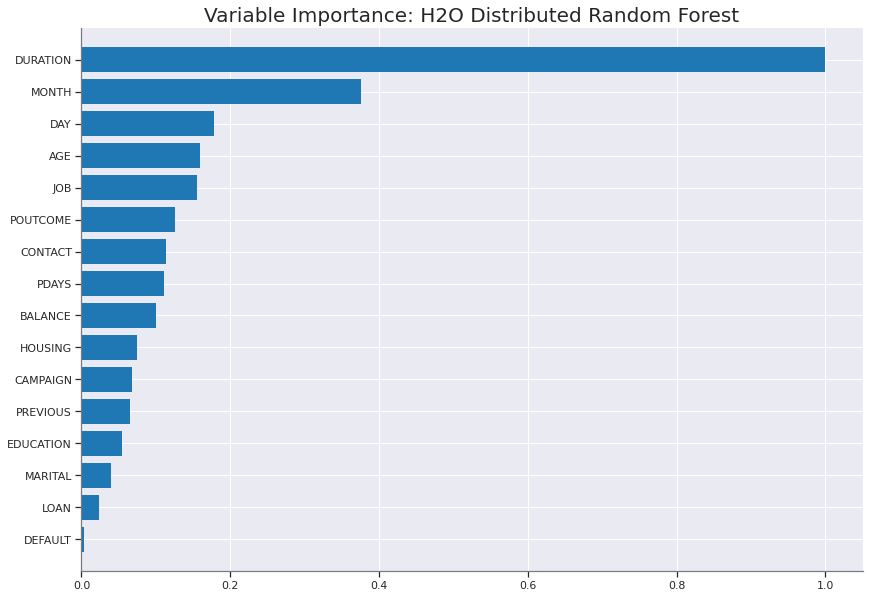

In [69]:
#look at important variable
base_model.varimp_plot(num_of_features=20)

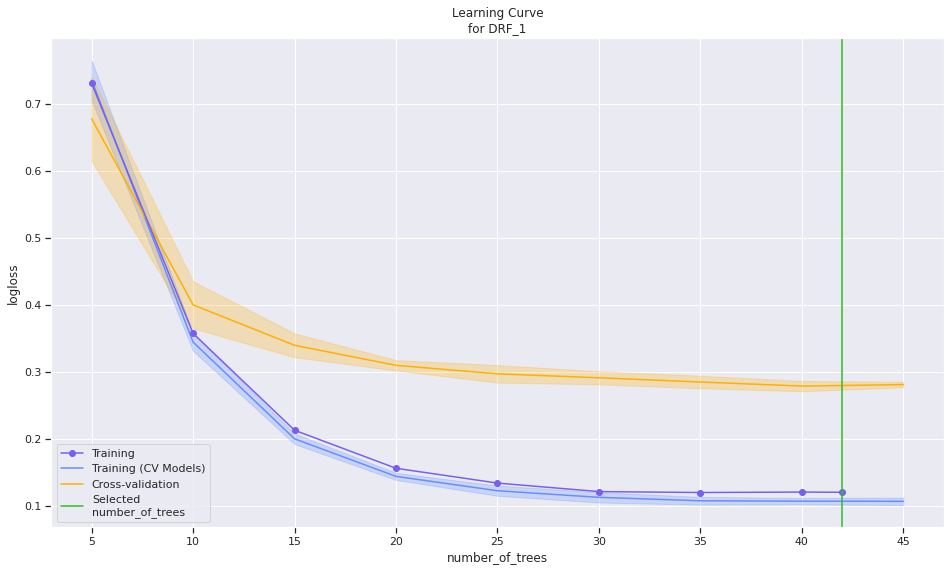

In [70]:
learning_curve_plot = base_model.learning_curve_plot()

## Base Learner Model Explainability

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## DRF_1_AutoML_1_20211009_213728


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.07411142578789318: 


,,no,yes,Error,Rate
0,no,8921.0,1026.0,0.1031,(1026.0/9947.0)
1,yes,255.0,1079.0,0.1912,(255.0/1334.0)
2,Total,9176.0,2105.0,0.1136,(1281.0/11281.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

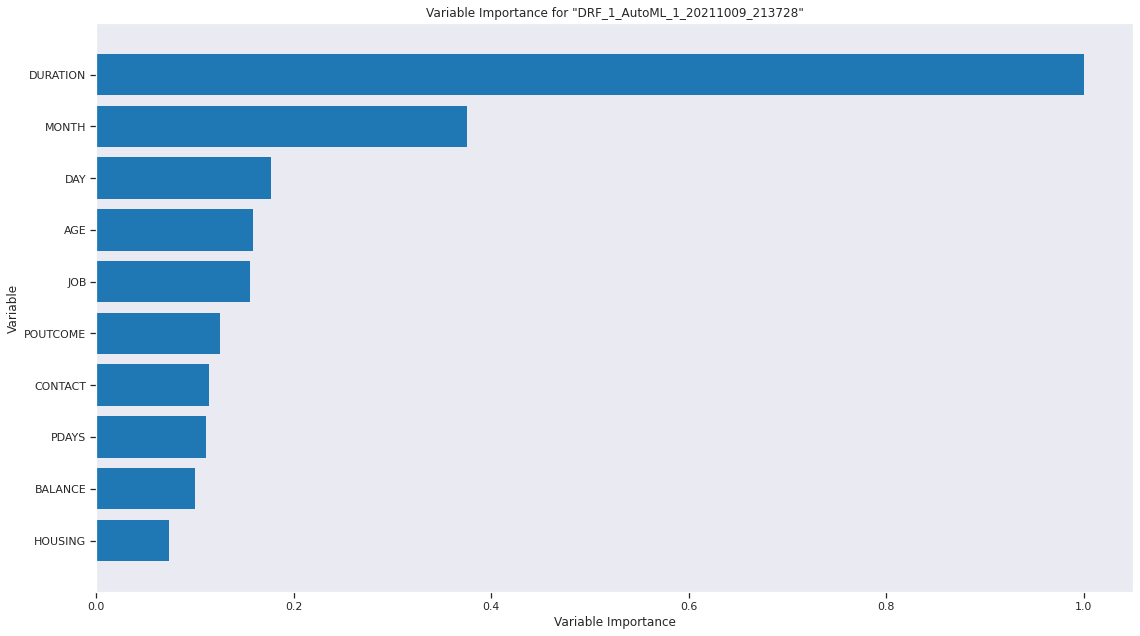

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

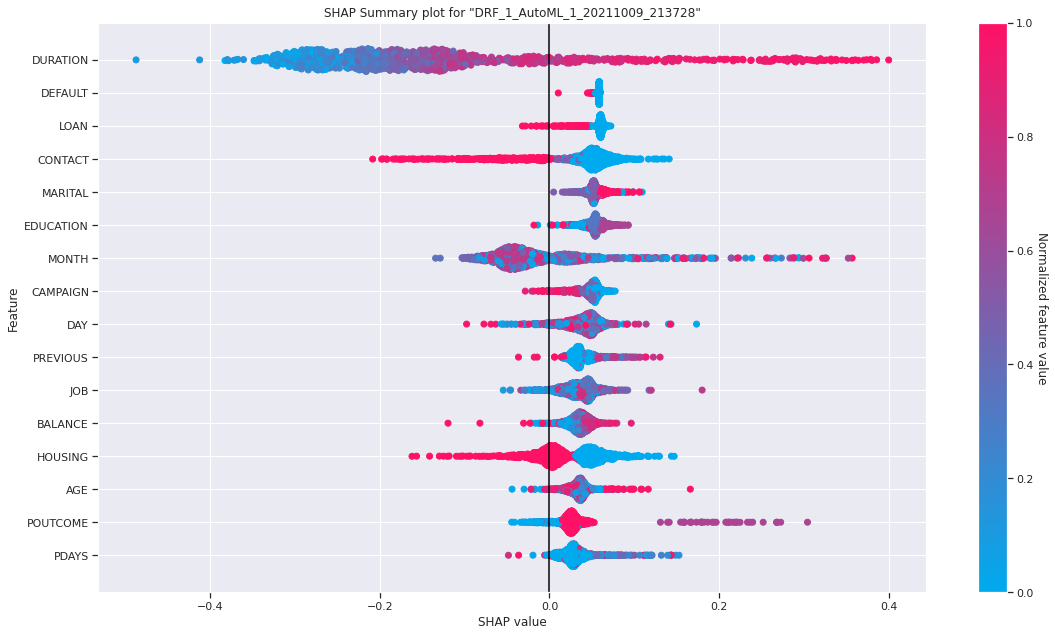

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

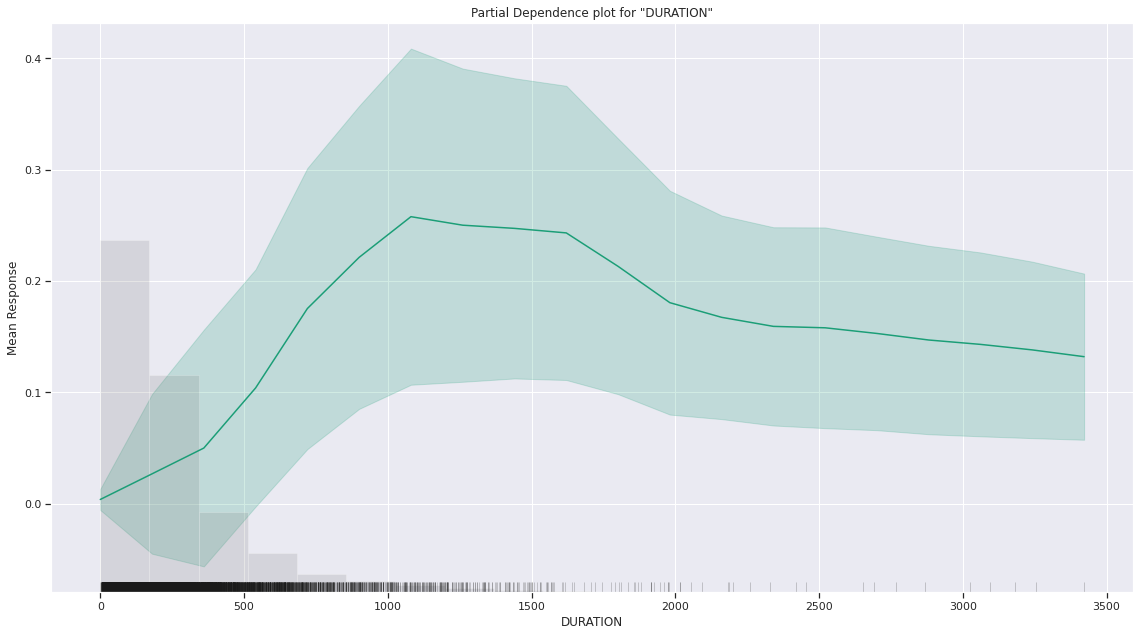

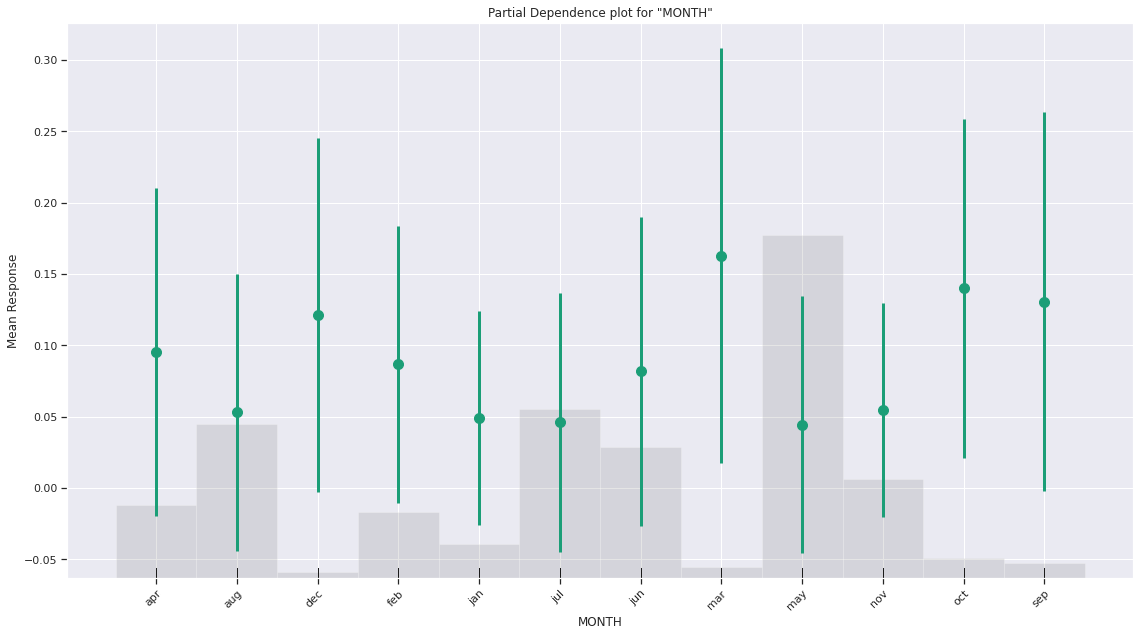

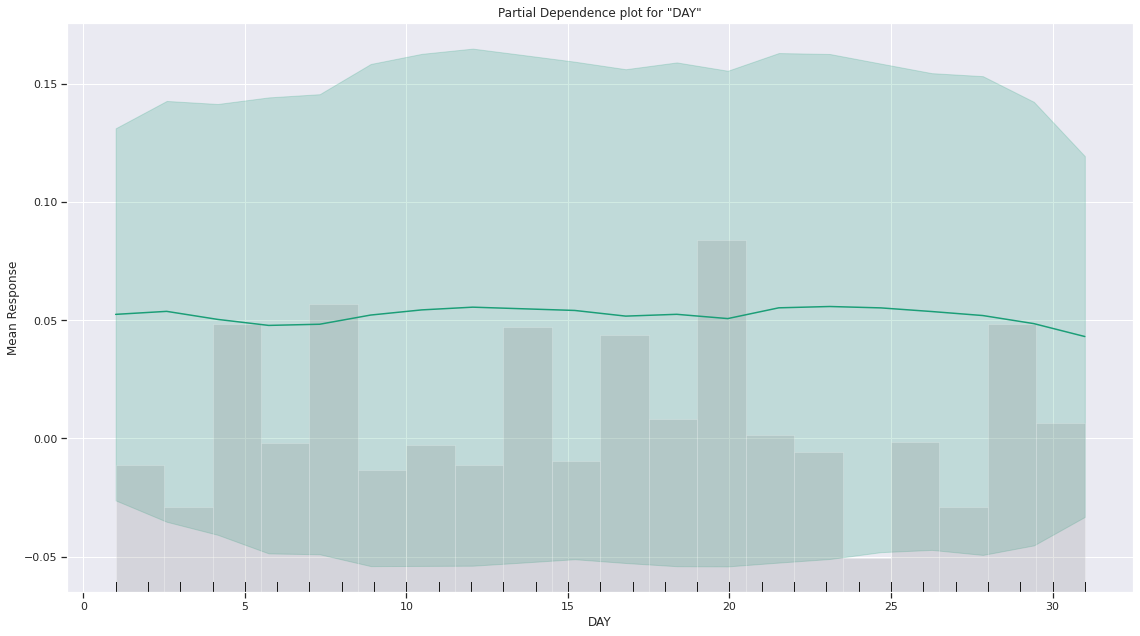

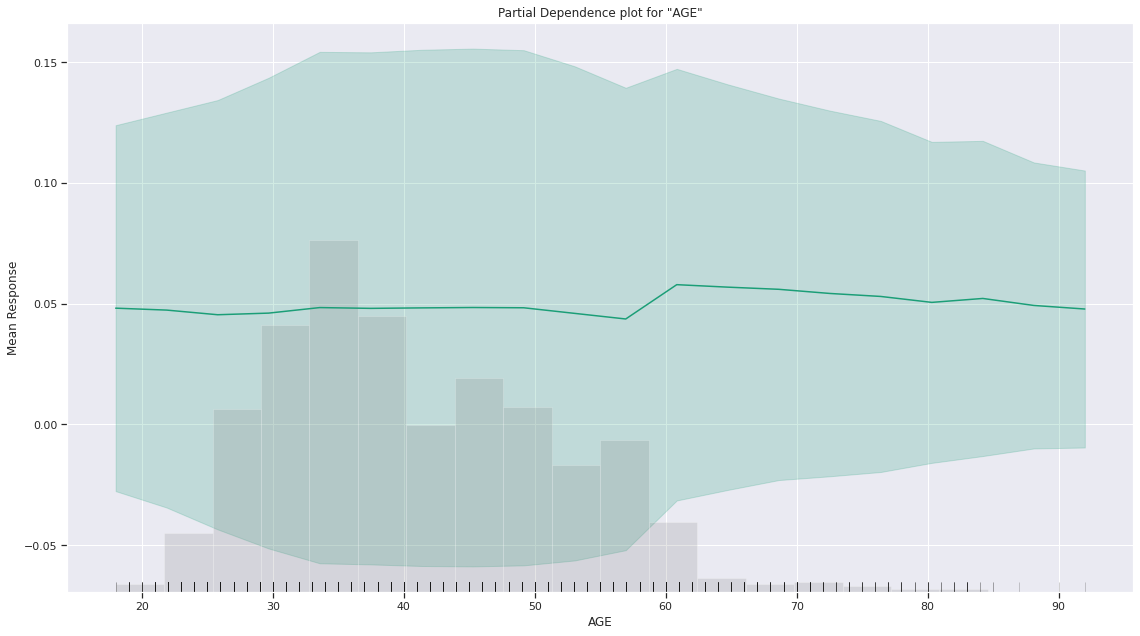

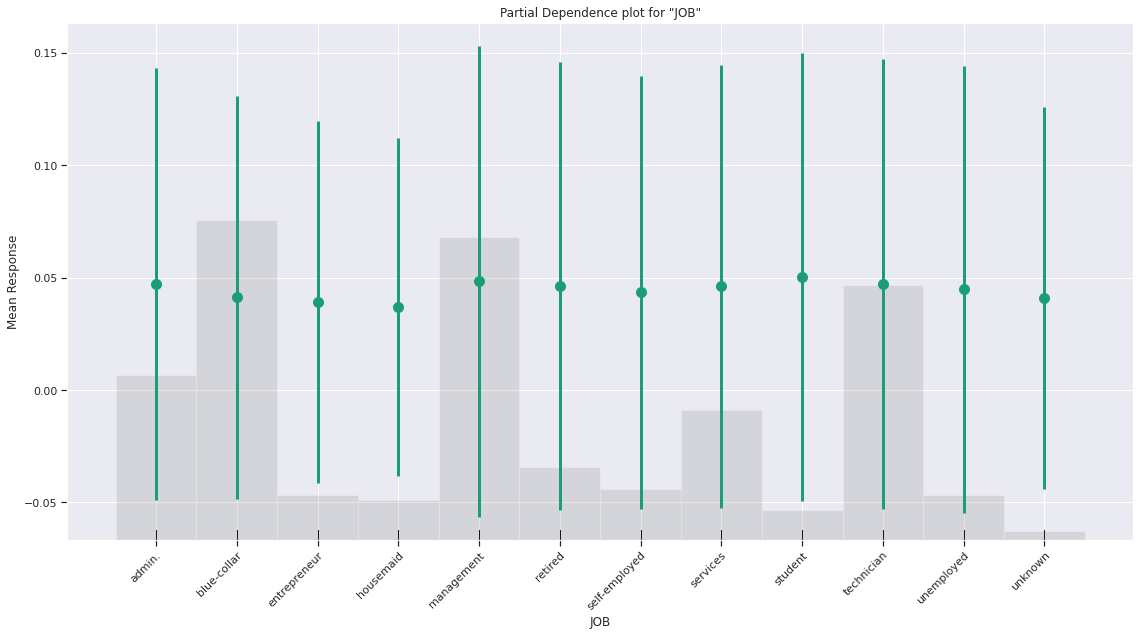

In [71]:
#explain a model
base_exm = base_model.explain(test)

# Make Prediction

In [72]:
#make prediction
preds = aml.leader.predict(test)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [73]:
#combine the prediction with the test dataset
df = test.cbind(preds)

#preview
df.head(10)

AGE,JOB,MARITAL,EDUCATION,DEFAULT,BALANCE,HOUSING,LOAN,CONTACT,DAY,MONTH,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,TERM_DEPOSIT,predict,no,yes
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,no,0.998888,0.00111241
35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no,no,0.999133,0.000866907
41,admin.,divorced,secondary,no,270,yes,no,unknown,5,may,222,1,-1,0,unknown,no,no,0.999033,0.000966577
29,admin.,single,secondary,no,390,yes,no,unknown,5,may,137,1,-1,0,unknown,no,no,0.998791,0.00120931
53,technician,married,secondary,no,6,yes,no,unknown,5,may,517,1,-1,0,unknown,no,no,0.930438,0.0695624
45,admin.,single,unknown,no,13,yes,no,unknown,5,may,98,1,-1,0,unknown,no,no,0.998914,0.00108618
36,technician,single,secondary,no,265,yes,yes,unknown,5,may,348,1,-1,0,unknown,no,no,0.99878,0.0012203
57,technician,married,secondary,no,839,no,yes,unknown,5,may,225,1,-1,0,unknown,no,no,0.991218,0.00878198
37,admin.,single,secondary,no,0,yes,no,unknown,5,may,137,1,-1,0,unknown,no,no,0.999054,0.000945948
50,management,married,secondary,no,49,yes,no,unknown,5,may,180,2,-1,0,unknown,no,no,0.998977,0.0010231


In [74]:
df = h2o.as_list(df)

preds = df[['TERM_DEPOSIT', 'predict']].head(20)
preds

,TERM_DEPOSIT,predict
0,no,no
1,no,no
2,no,no
3,no,no
4,no,no
5,no,no
6,no,no
7,no,no
8,no,no
9,no,no


In [76]:
df.to_csv('df.csv')

In [75]:
preds.to_csv('preds.csv')